In [1]:
from skimage import io, exposure, transform, filters, segmentation, color, morphology
from skimage.future import graph

import matplotlib.pyplot as plt
import numpy as np
from copy import copy
import glob
import os
import tifftools
import time



Code to test different thresholding and segmentation methods on zebrafish embryo 2D maximum intensity projections. Input file is expected to be a 1 channel time series in tif format.

## Read image data

In [2]:
targetFolder = "D:/ZED/12MIPS/"
test_run = "ProblemSet_Scan"
fzScale=100
fz_minimum_size = 20000
gaussianSigma = 4
outputDirectory = targetFolder+test_run
outputDirectoryExistsCheck = os.path.exists(outputDirectory)
#Define color palette and background masking color
palette = copy(plt.cm.gray)
palette.set_under('r', alpha=1)

if not outputDirectoryExistsCheck:
    os.mkdir(outputDirectory)

In [3]:
imageStack = glob.glob('D:/ZED/12MIPS/embryo*.tif') # stack of frames
#Pick out specific frames

s = 0
test_images = []
for stack in imageStack:
    print(stack)
    stack = io.imread(stack)
    if s==2:
        test_images.append(stack[0,0::])
        test_images.append(stack[1*12,1*12::])
    if s==4:
        test_images.append(stack[0,0::])
        test_images.append(stack[5*12,5*12::])
    if s==6:
        test_images.append(stack[15*12,15*12::])
    if s==8:
        test_images.append(stack[5*12,5*12::])
        test_images.append(stack[15*12,15*12::])
    if s==9:
        test_images.append(stack[15*12,15*12::])
    if s==10:
        test_images.append(stack[0,0::])
        test_images.append(stack[5*12,5*12::])
    if s==11:
        test_images.append(stack[10*12,10*12::])
        test_images.append(stack[15*12,15*12::])
    s=s+1

D:/ZED/12MIPS\embryo1.tif
D:/ZED/12MIPS\embryo10.tif
D:/ZED/12MIPS\embryo11.tif
D:/ZED/12MIPS\embryo12.tif
D:/ZED/12MIPS\embryo2.tif
D:/ZED/12MIPS\embryo3.tif
D:/ZED/12MIPS\embryo4.tif
D:/ZED/12MIPS\embryo5.tif
D:/ZED/12MIPS\embryo6.tif
D:/ZED/12MIPS\embryo7.tif
D:/ZED/12MIPS\embryo8.tif
D:/ZED/12MIPS\embryo9.tif


In [4]:
# Function definitions for merging labels
# Adopted from: https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_rag_merge.html#sphx-glr-auto-examples-segmentation-plot-rag-merge-py

### RAG merging
def _weight_mean_color(graph, src, dst, n):
    """Callback to handle merging nodes by recomputing mean color.

    The method expects that the mean color of `dst` is already computed.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    n : int
        A neighbor of `src` or `dst` or both.

    Returns
    -------
    data : dict
        A dictionary with the `"weight"` attribute set as the absolute
        difference of the mean color between node `dst` and `n`.
    """

    diff = graph.nodes[dst]['mean color'] - graph.nodes[n]['mean color']
    diff = np.linalg.norm(diff)
    return {'weight': diff}


def merge_mean_color(graph, src, dst):
    """Callback called before merging two nodes of a mean color distance graph.

    This method computes the mean color of `dst`.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    """
    graph.nodes[dst]['total color'] += graph.nodes[src]['total color']
    graph.nodes[dst]['pixel count'] += graph.nodes[src]['pixel count']
    graph.nodes[dst]['mean color'] = (graph.nodes[dst]['total color'] /
                                      graph.nodes[dst]['pixel count'])

def m_h(img, segments):
    g = graph.rag_mean_color(img, segments, mode='distance')
    segments_mh = graph.merge_hierarchical(segments, g, thresh=0.2, rag_copy=False,
                                   in_place_merge=True,
                                   merge_func=merge_mean_color,
                                   weight_func=_weight_mean_color)
    out_mh = color.label2rgb(segments_mh, img, bg_label=0)
    return out_mh



In [5]:
#match sample names and time points with images
def setname(a,b):
    if a==0 and b==0:
        return "E11T1"
    if a==0 and b==1:
        return "E11T13"
    if a==0 and b==2:
        return "E2T1"
    if a==1 and b==0:
        return "E2T61"
    if a==1 and b==1:
        return "E4T181"
    if a==1 and b==2:
        return "E6T61"
    if a==2 and b==0:
        return "E6T181"
    if a==2 and b==1:
        return "E7T181"
    if a==2 and b==2:
        return "E8T1"
    if a==3 and b==0:
        return "E8T61"
    if a==3 and b==1:
        return "E9T61"
    if a==3 and b==2:
        return "E9T181"
        

# Below this point is the runnable code.

715.3716685771942


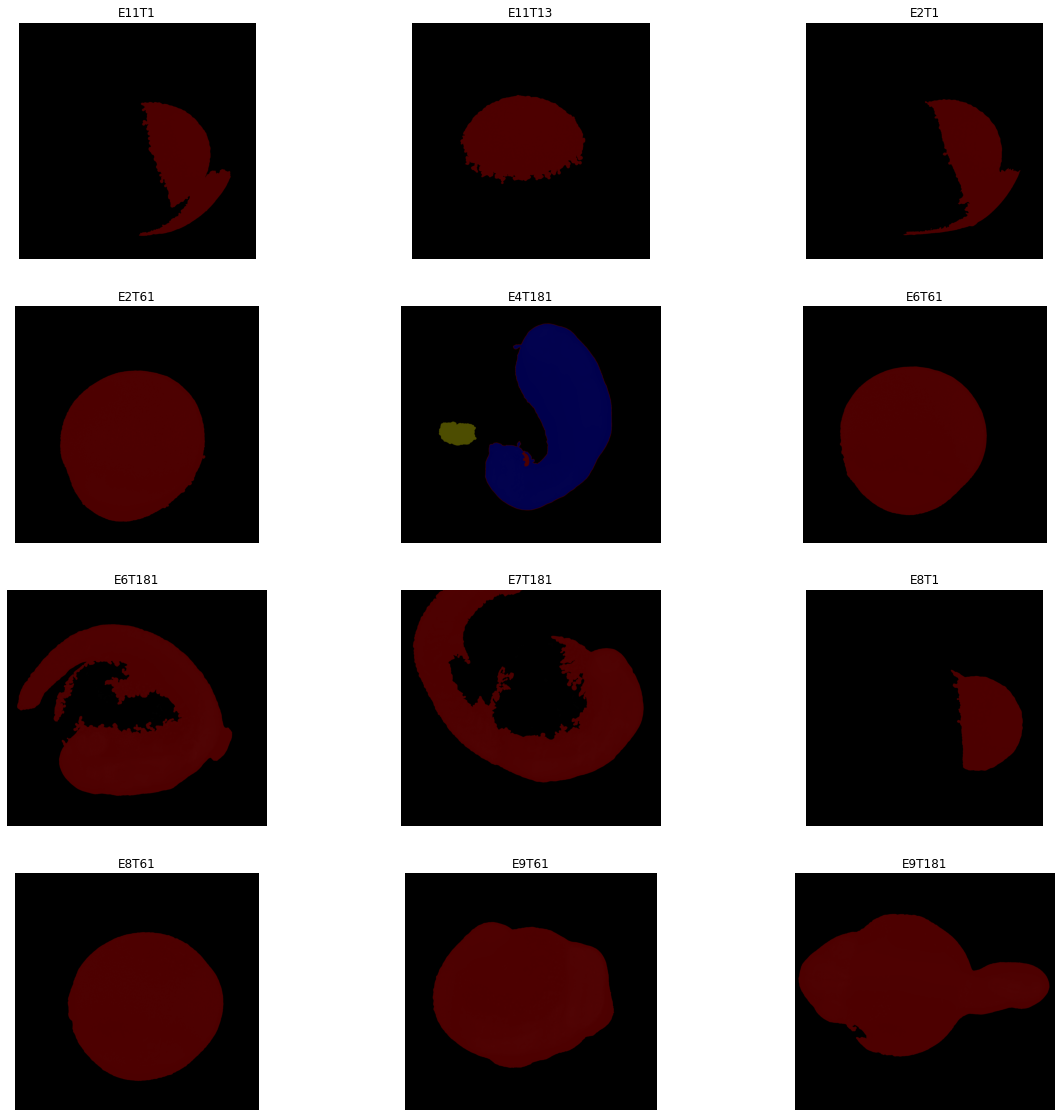

In [6]:
start = time.time()

n = 0
fig, ax = plt.subplots(4, 3, figsize=(20, 20))
for image in test_images:

    #print(np.shape(image))
    #fig = plt.figure(figsize=(6, 6))
    image_g = filters.gaussian(image, sigma=gaussianSigma, preserve_range=True)
#     a=int(np.floor(n/3))
#     b = int(n%3)
#     title = setname(a,b)
#     fig, ax = filters.try_all_threshold(image_g, figsize=(10, 8), verbose=False)
#     plt.show()
#     imageFileName = outputDirectory+"/embryo_"+title+"_test.tif"
#     fig.savefig(imageFileName)
    
    hist_threshold = filters.threshold_triangle(image_g)
    mask = image_g > hist_threshold
    mask = morphology.area_opening(mask, area_threshold = 2000)
    #mask = binary_closing(mask)
    image_t =image * mask
    segments_fz = segmentation.felzenszwalb(image_t, scale=fzScale, sigma=1, min_size=fz_minimum_size)

    fz_cut = m_h(image_t, segments_fz)
    
    a=int(np.floor(n/3))
    b = int(n%3)
    #ax[a,b].imshow(image_t,vmin=0.001, cmap=palette)
    ax[a,b].imshow(fz_cut)
    title = setname(a,b)
    ax[a,b].set_title(title)
    ax[a,b].axis('off')
    n=n+1
    
imageFileName = outputDirectory+"/embryo_mask"+test_run+"_RAG_fz_area_opening.tif"

plt.savefig(imageFileName, transparent=True)

end = time.time()
print(end - start)




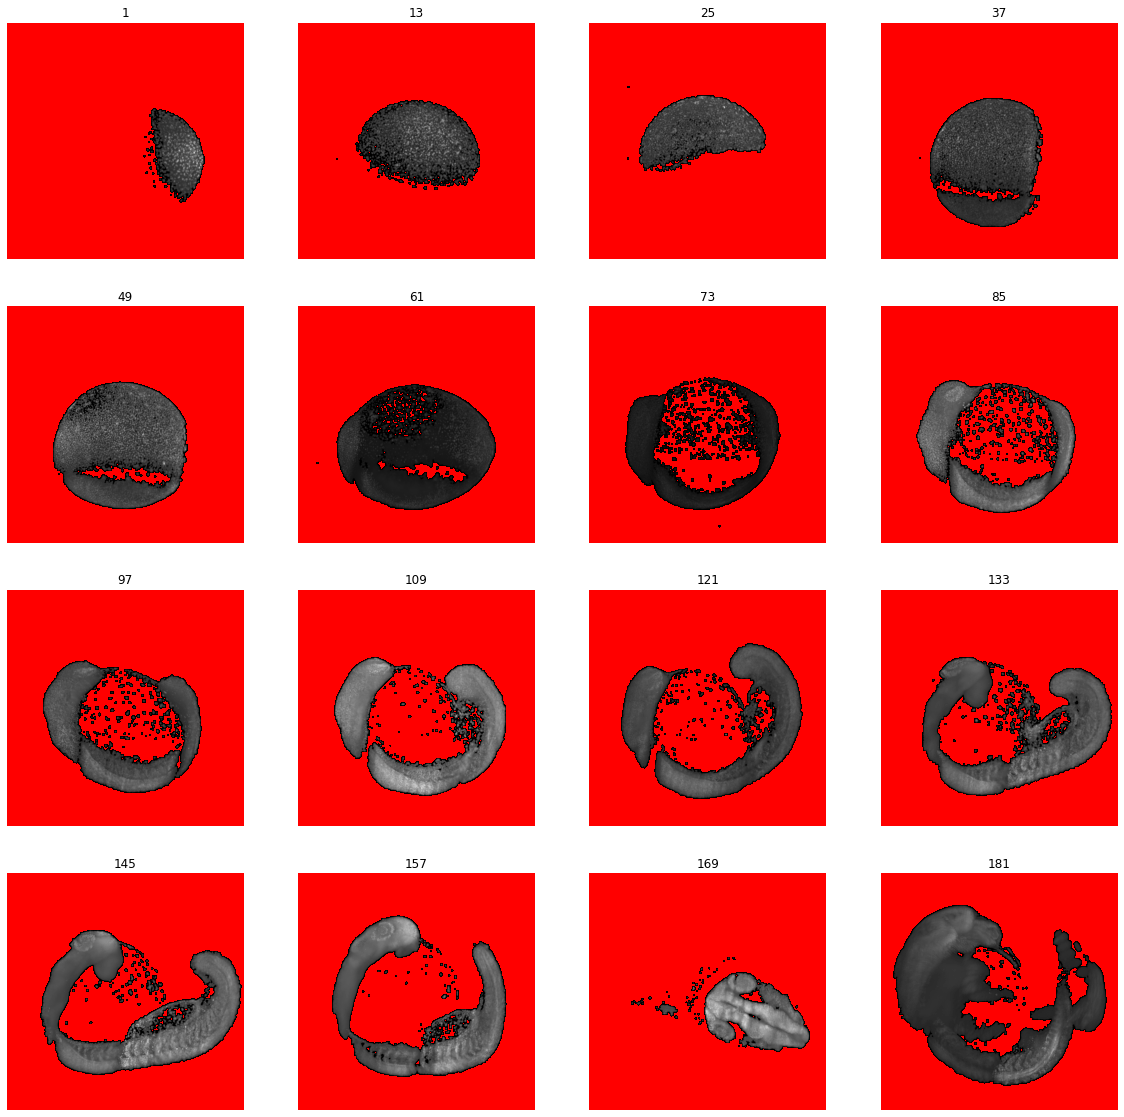

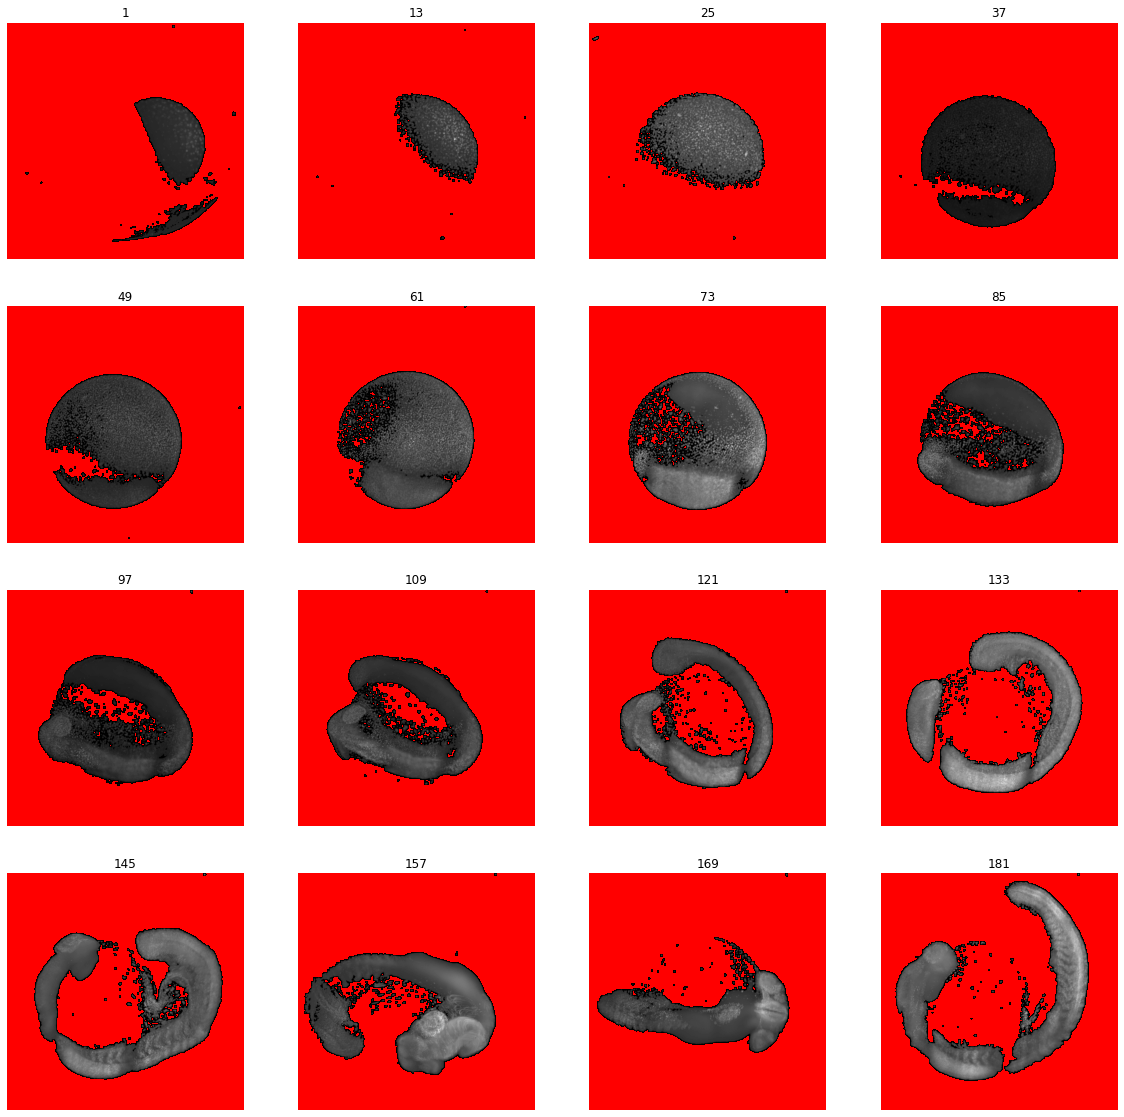

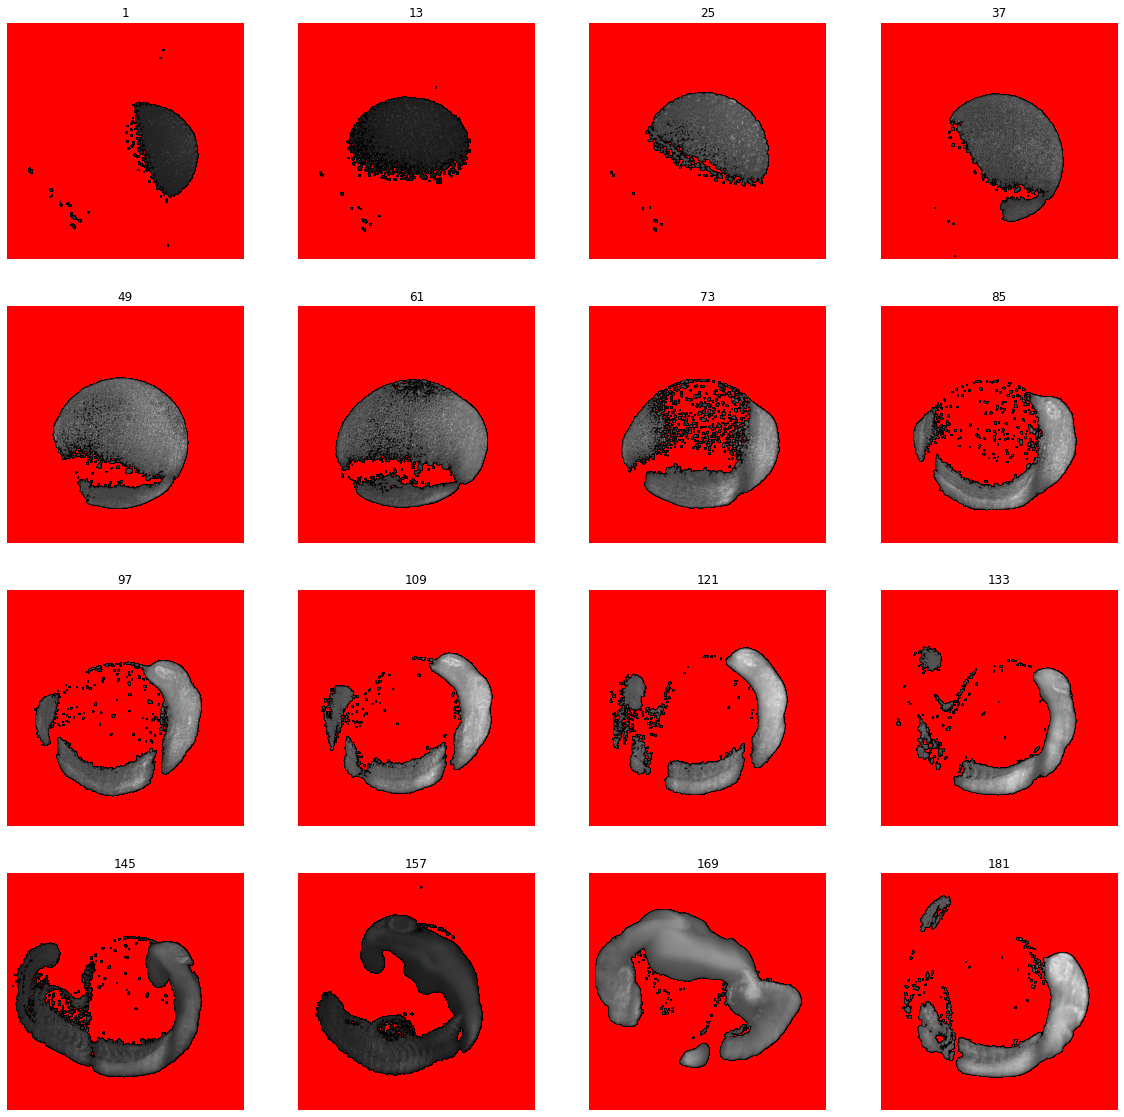

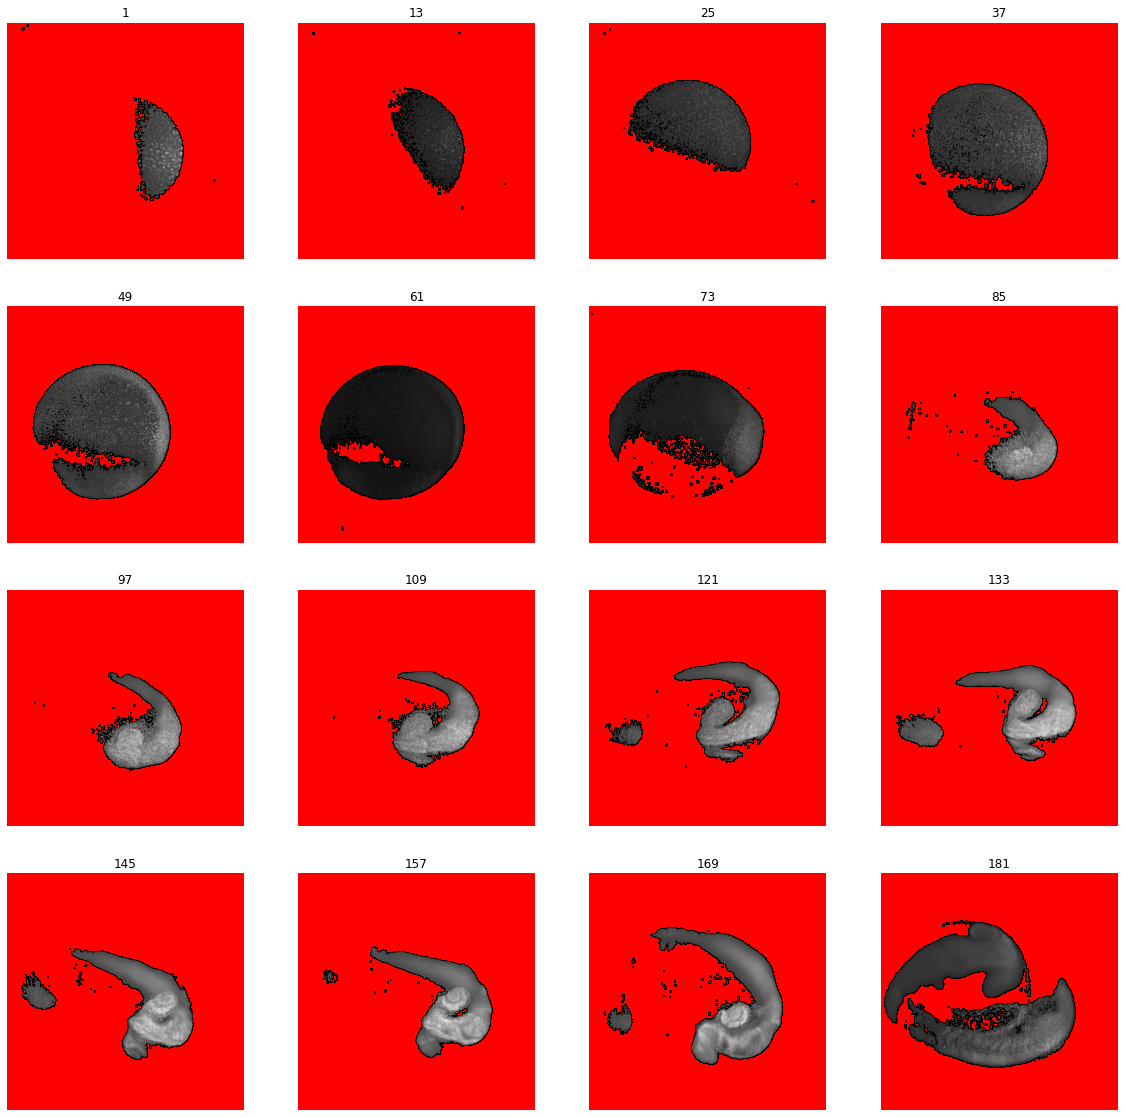

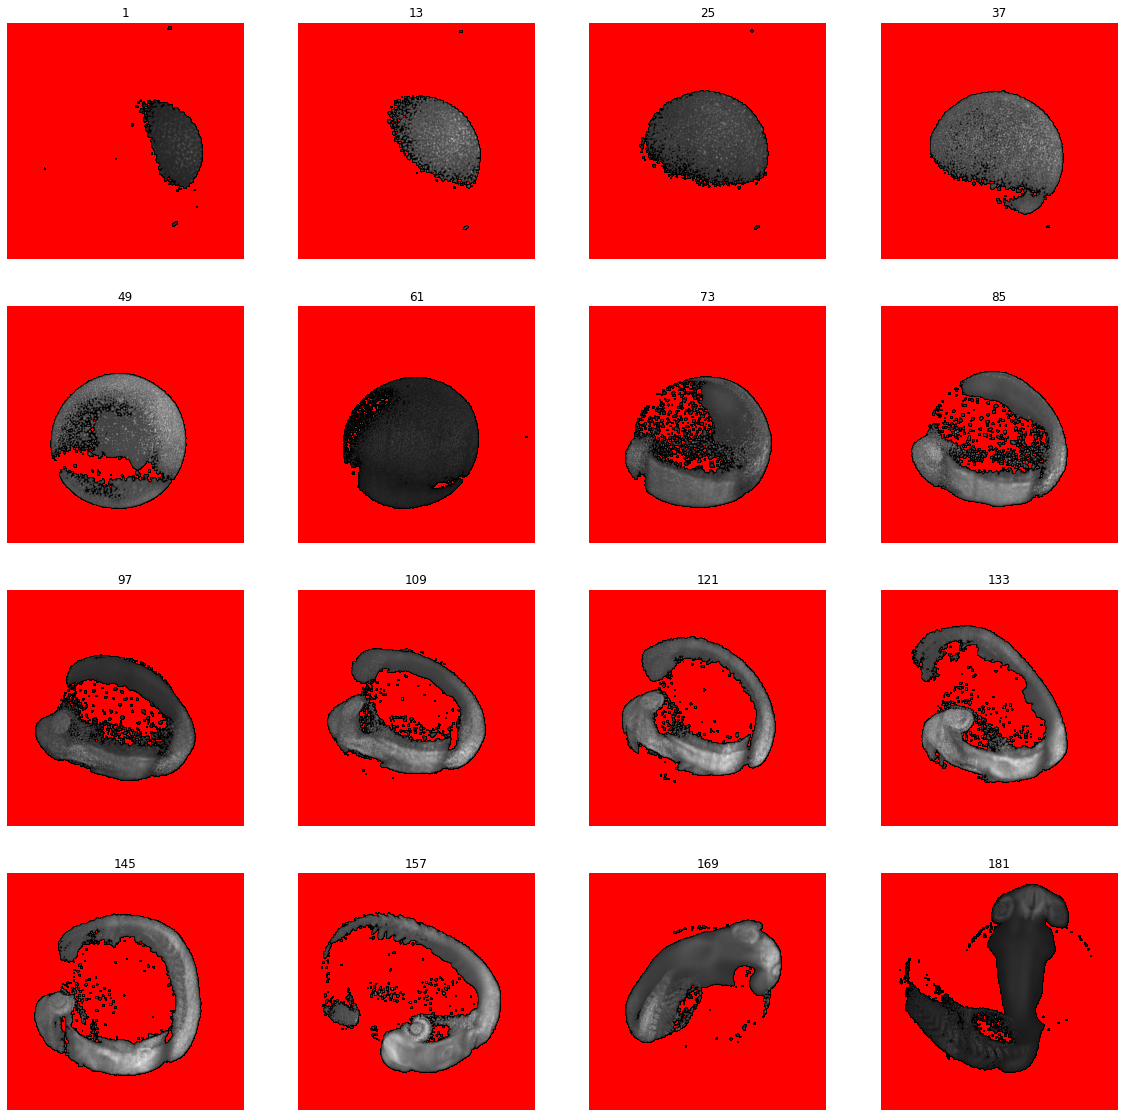

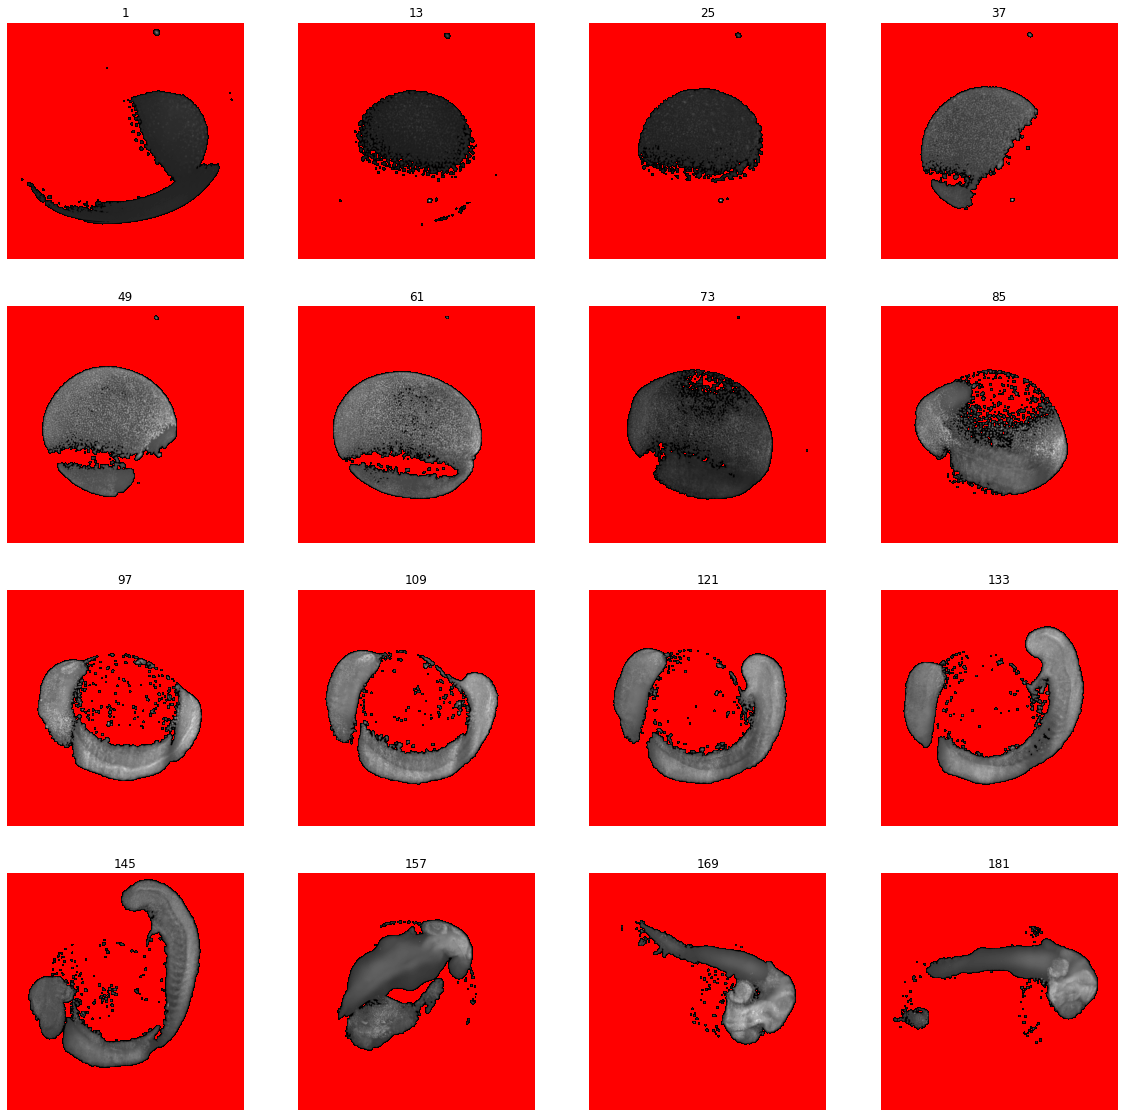

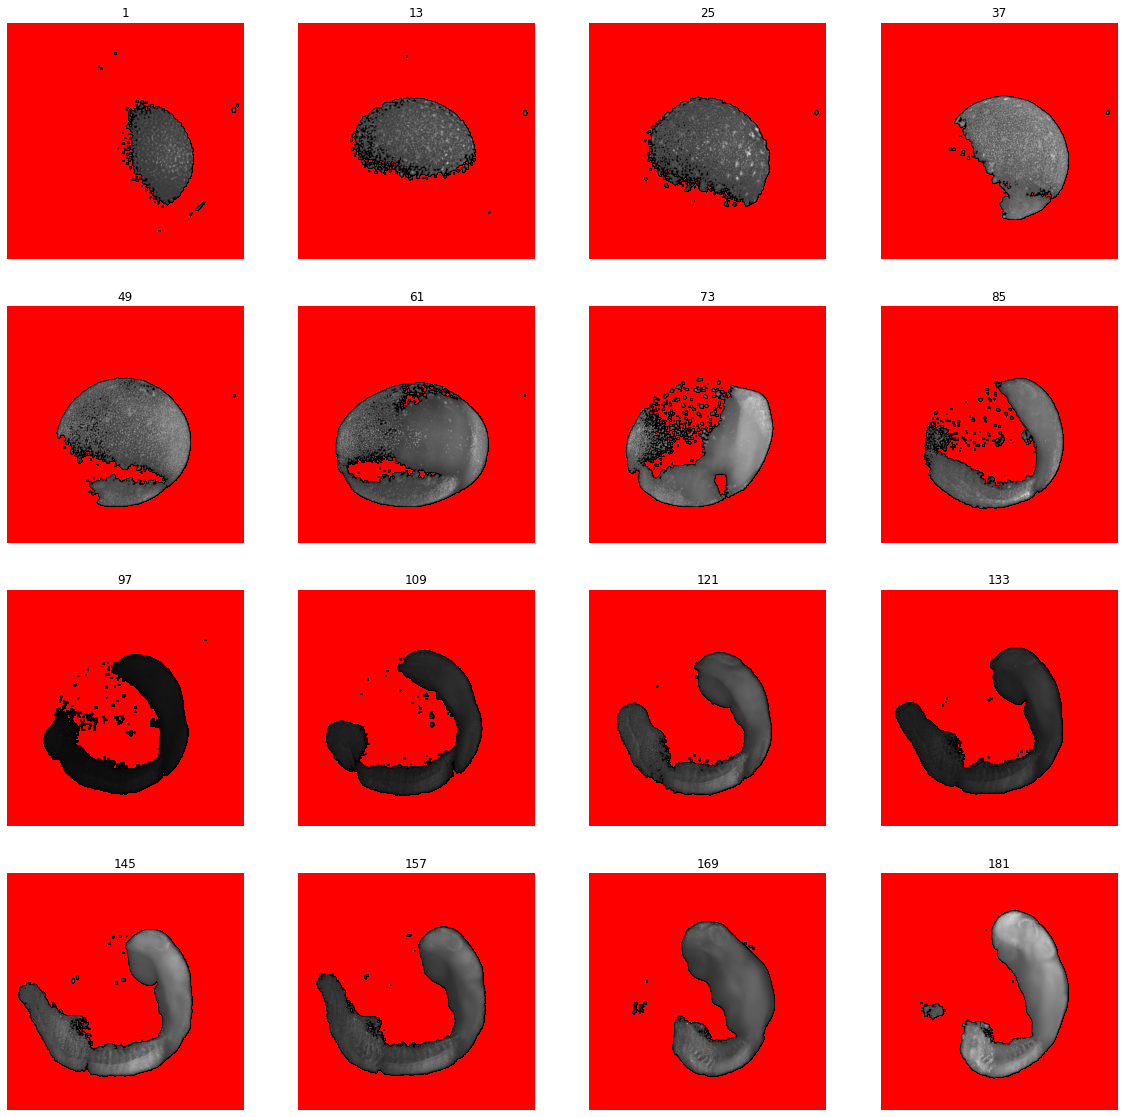

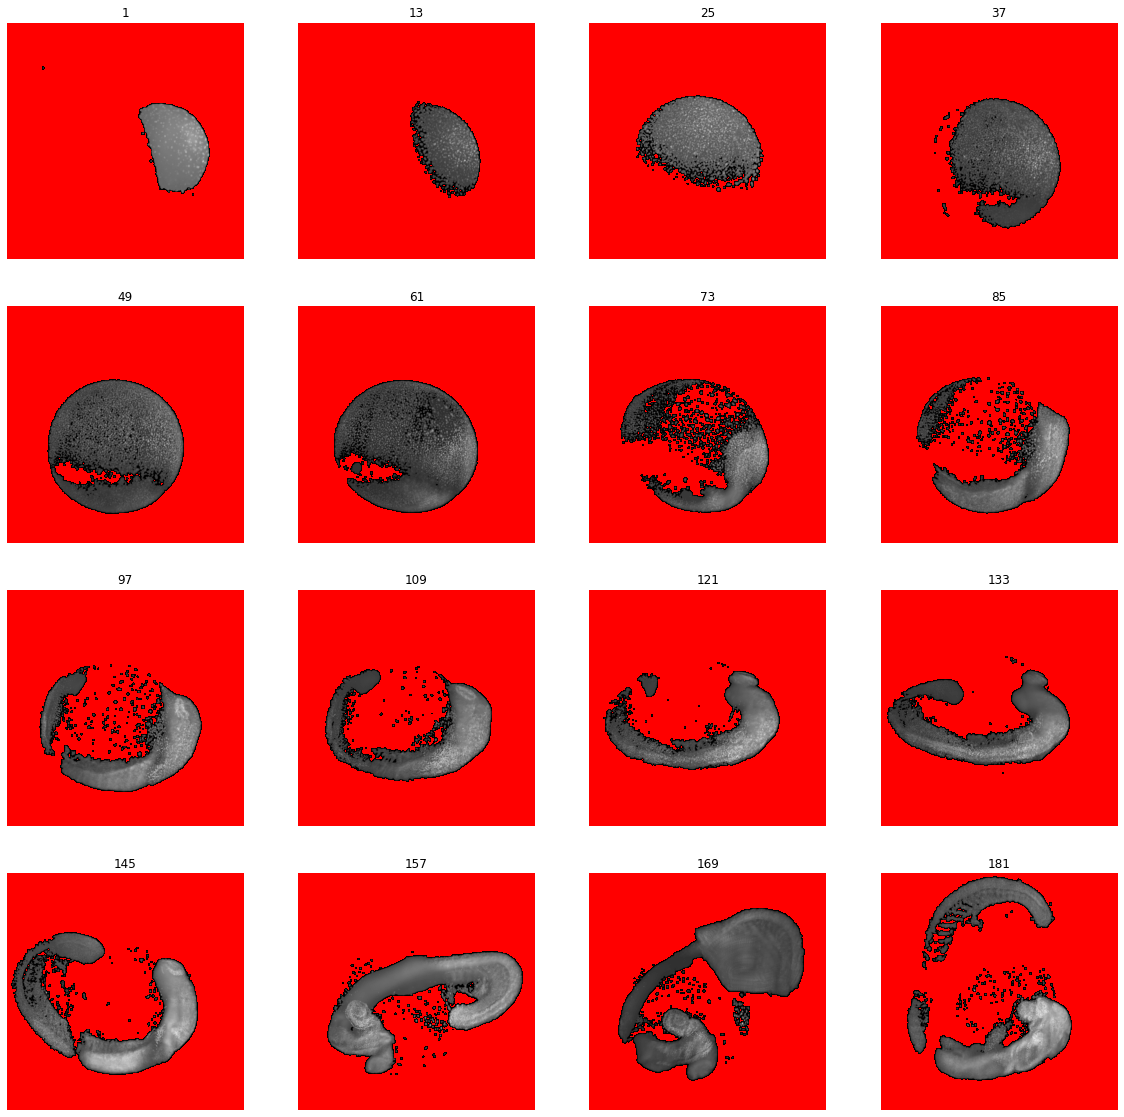

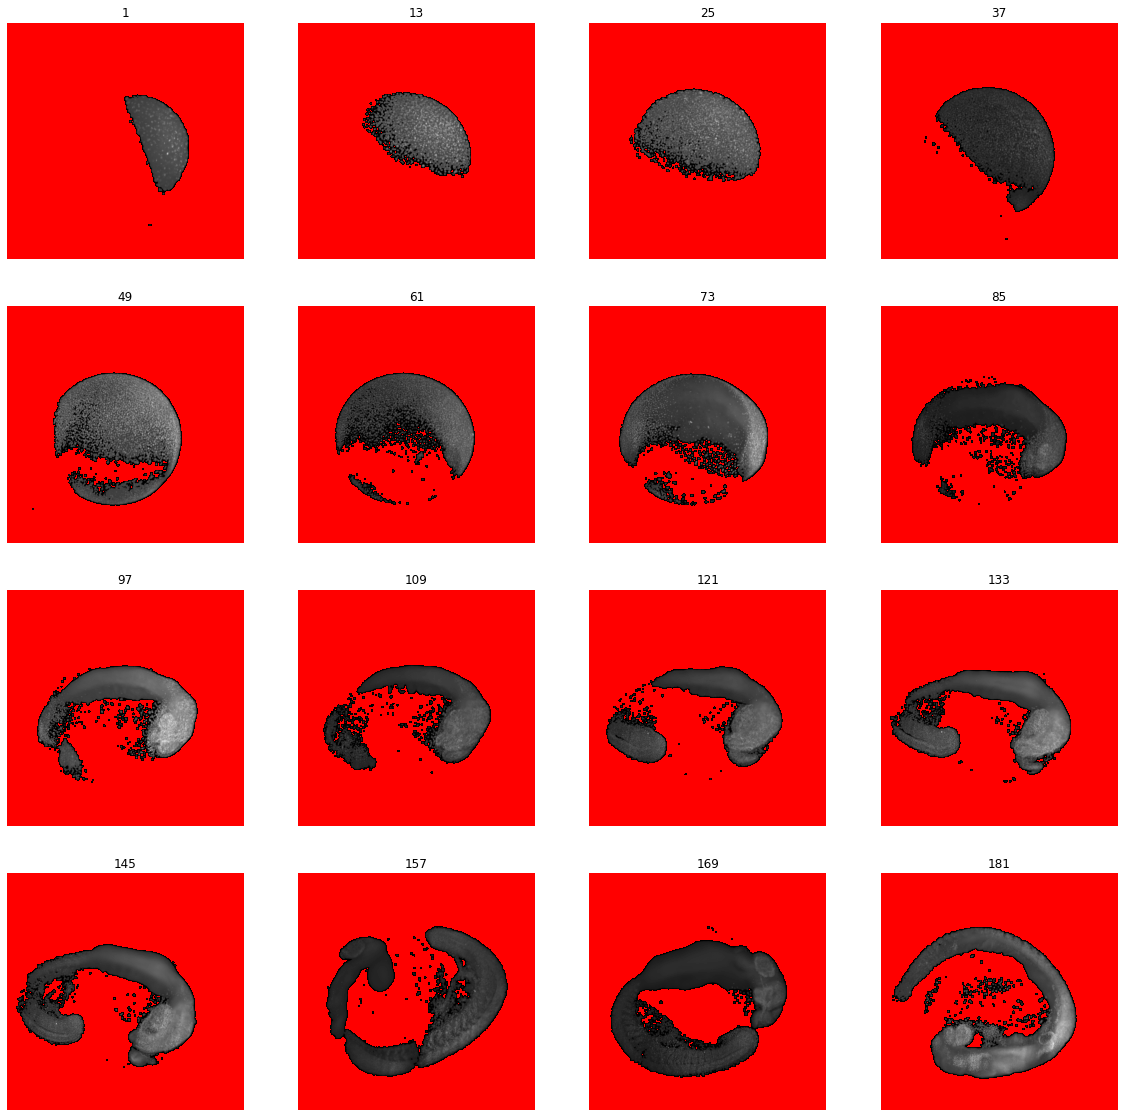

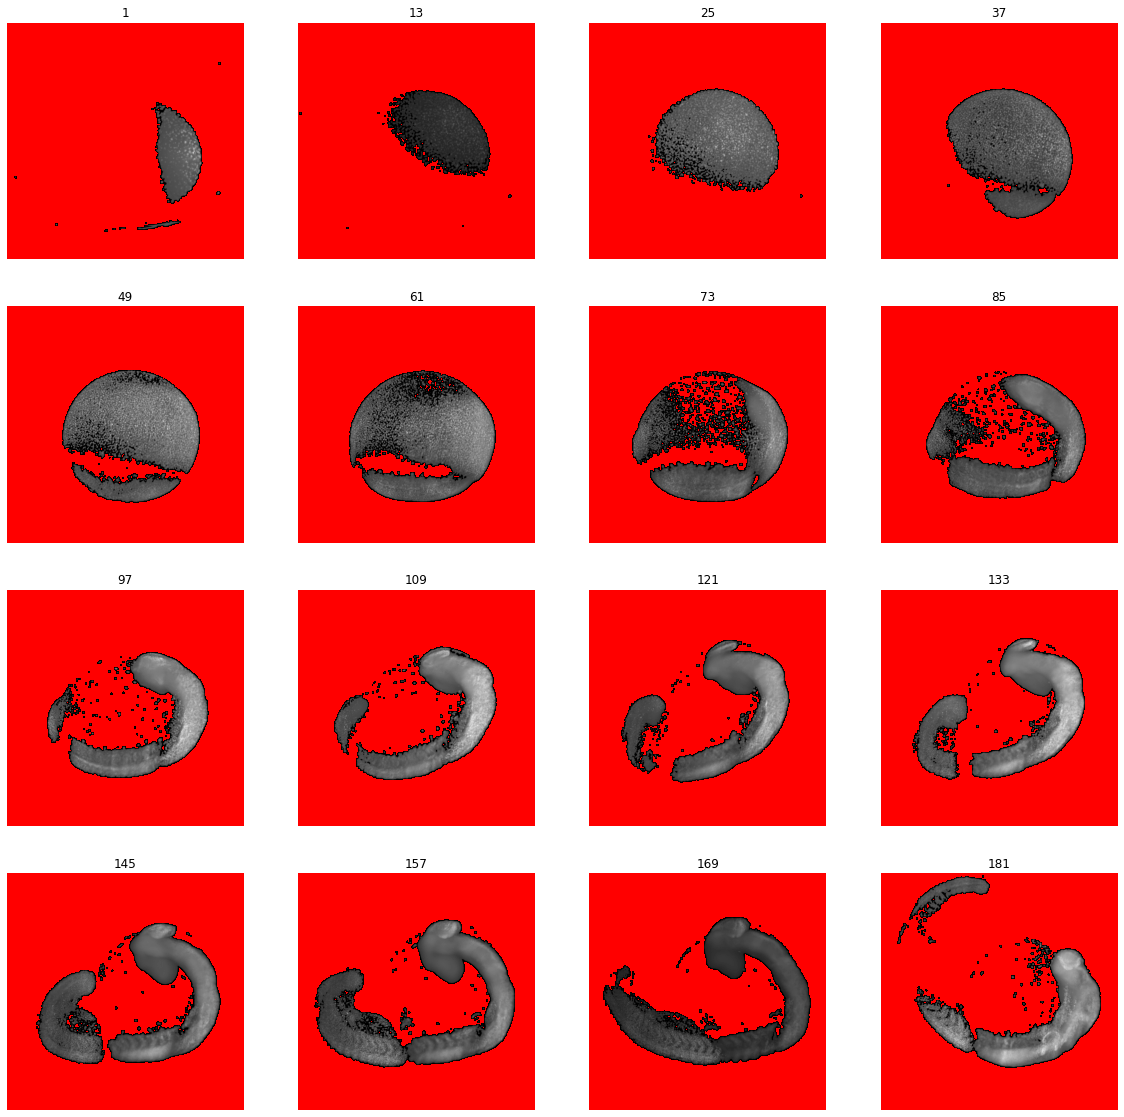

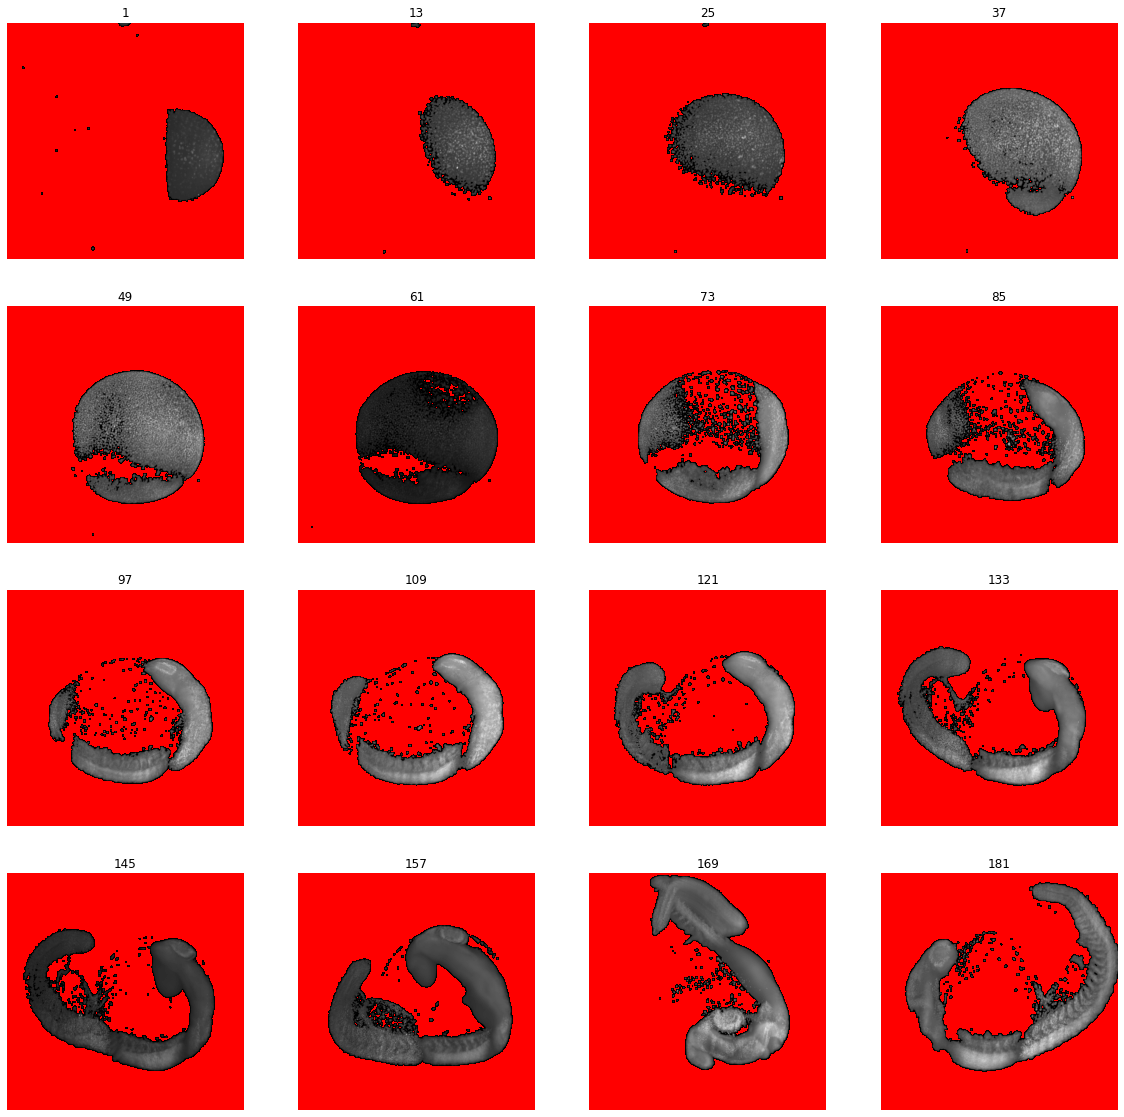

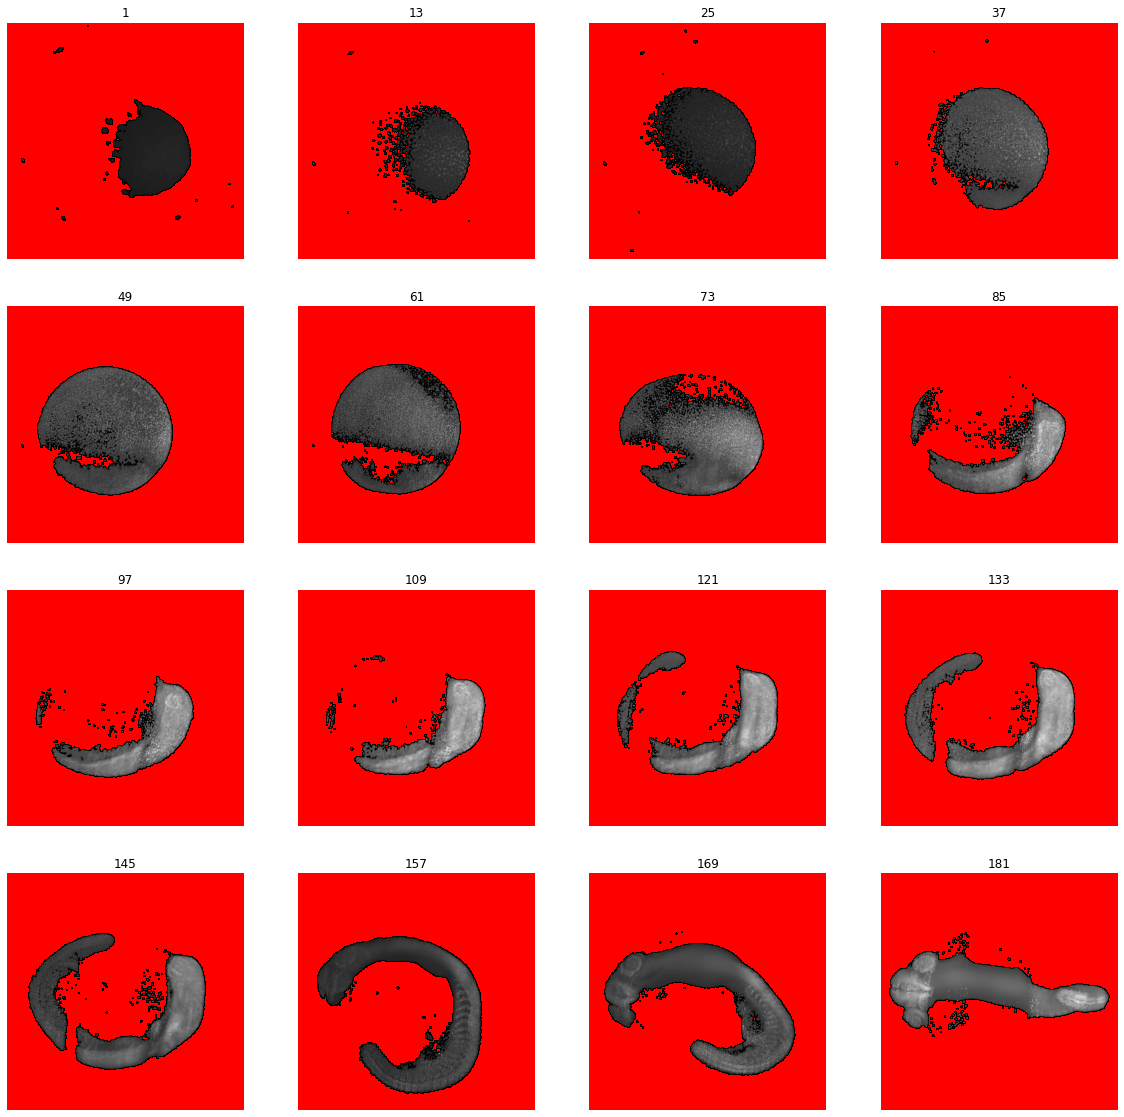

In [22]:

#print (np.shape(imageStack))
s = 1
for stack in imageStack:
    stack = io.imread(stack)
    substack = stack[::12]
    #print (np.shape(stack))
    #print (np.shape(substack))
    n=0
    
    fig, ax = plt.subplots(4, 4, figsize=(20, 20))


    for slice in substack:
        #Gaussian blur on original image - multiple to get back original values
        slice_g = filters.gaussian(slice, sigma=gaussianSigma, preserve_range=True)
        
        hist_threshold = filters.threshold_otsu(slice_g)
        mask = slice_g > hist_threshold
        slice_t = slice * mask

        a=int(np.floor(n/4))
        b = int(n%4)
        ax[a,b].imshow(slice_t, vmin=0.01, cmap=palette)
        ax[a,b].set_title(1+n*12)
        ax[a,b].axis('off')
        n=n+1

    imageFileName = targetFolder+"otsu_"+"/embryo_"+str(s)+"_otsu_"+".tif"

    plt.savefig(imageFileName, transparent=True)
    s=s+1

In [23]:
#Stop Iteration error means the outputDirectory is not found - did you delete, move,rename the folder?
root, dirs, files = next(os.walk(outputDirectory, topdown=True))
files = [ os.path.join(root, f) for f in files ]
print(files)
tifftools.tiff_concat(files, targetFolder+"combined_tifs/otsu"+".tif", overwrite=True)

['D:/ZED/12MIPS/otsu_94\\embryo_10_otsu_.tif', 'D:/ZED/12MIPS/otsu_94\\embryo_11_otsu_.tif', 'D:/ZED/12MIPS/otsu_94\\embryo_12_otsu_.tif', 'D:/ZED/12MIPS/otsu_94\\embryo_1_otsu_.tif', 'D:/ZED/12MIPS/otsu_94\\embryo_2_otsu_.tif', 'D:/ZED/12MIPS/otsu_94\\embryo_3_otsu_.tif', 'D:/ZED/12MIPS/otsu_94\\embryo_4_otsu_.tif', 'D:/ZED/12MIPS/otsu_94\\embryo_5_otsu_.tif', 'D:/ZED/12MIPS/otsu_94\\embryo_6_otsu_.tif', 'D:/ZED/12MIPS/otsu_94\\embryo_7_otsu_.tif', 'D:/ZED/12MIPS/otsu_94\\embryo_8_otsu_.tif', 'D:/ZED/12MIPS/otsu_94\\embryo_9_otsu_.tif']


(-0.5, 511.5, 511.5, -0.5)

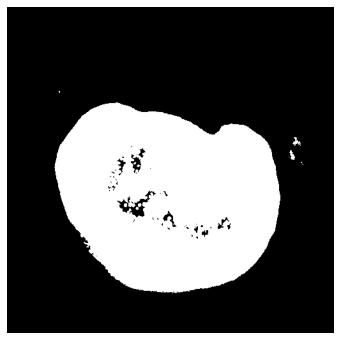

In [19]:
### download the dataset from: https://drive.google.com/drive/folders/1_mnNa7crtrIO4-qtJPx45eBCtBT4UZ7p?usp=sharing

stack = io.imread('D:/ZED/12MIPS/embryo1.tif') # stack of frames
slice = stack[100] # pick one frame
slice = transform.resize(exposure.rescale_intensity(slice, out_range=(0, 1)), (512, 512)) # normalize and resize
triangle_threshold = filters.threshold_triangle(slice)
binary = slice > triangle_threshold
slice = slice*binary

fig = plt.figure(figsize=(6, 6))
plt.imshow(binary, cmap=plt.cm.gray)
plt.axis('off')


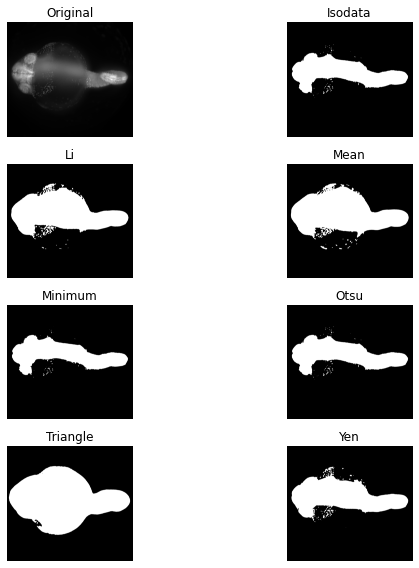

In [23]:
### Testing all thresholds
########################
fig, ax = filters.try_all_threshold(image_g, figsize=(10, 8), verbose=False)
plt.show()
fig.savefig("test.tif")
#Triangle looks best across a variety of slices

## First, threshold the backgroud

(-0.5, 511.5, 511.5, -0.5)

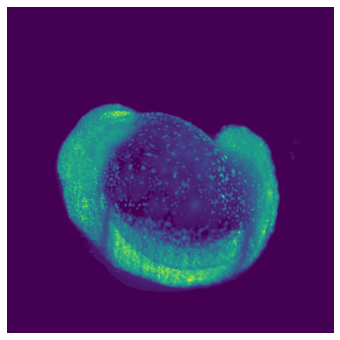

In [47]:
# mask = slice > np.percentile(slice, 70) # pick a threshold that removes the background
# slice_t = slice * mask
# fig = plt.figure(figsize=(6, 6))
# plt.imshow(slice_t)
# plt.axis('off')

## Generate superpixels (over-segmented intermediate resutls)

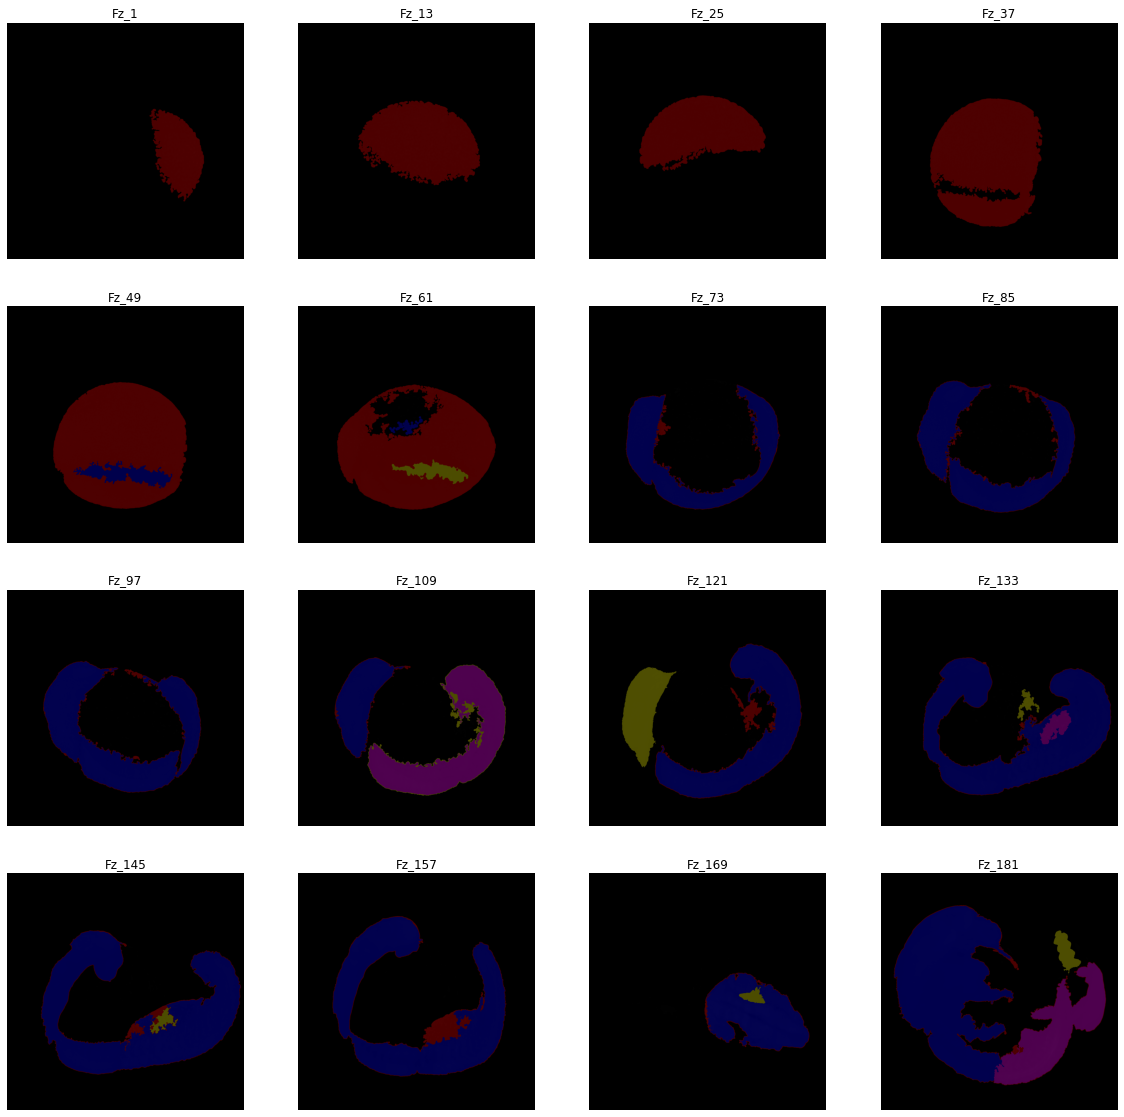

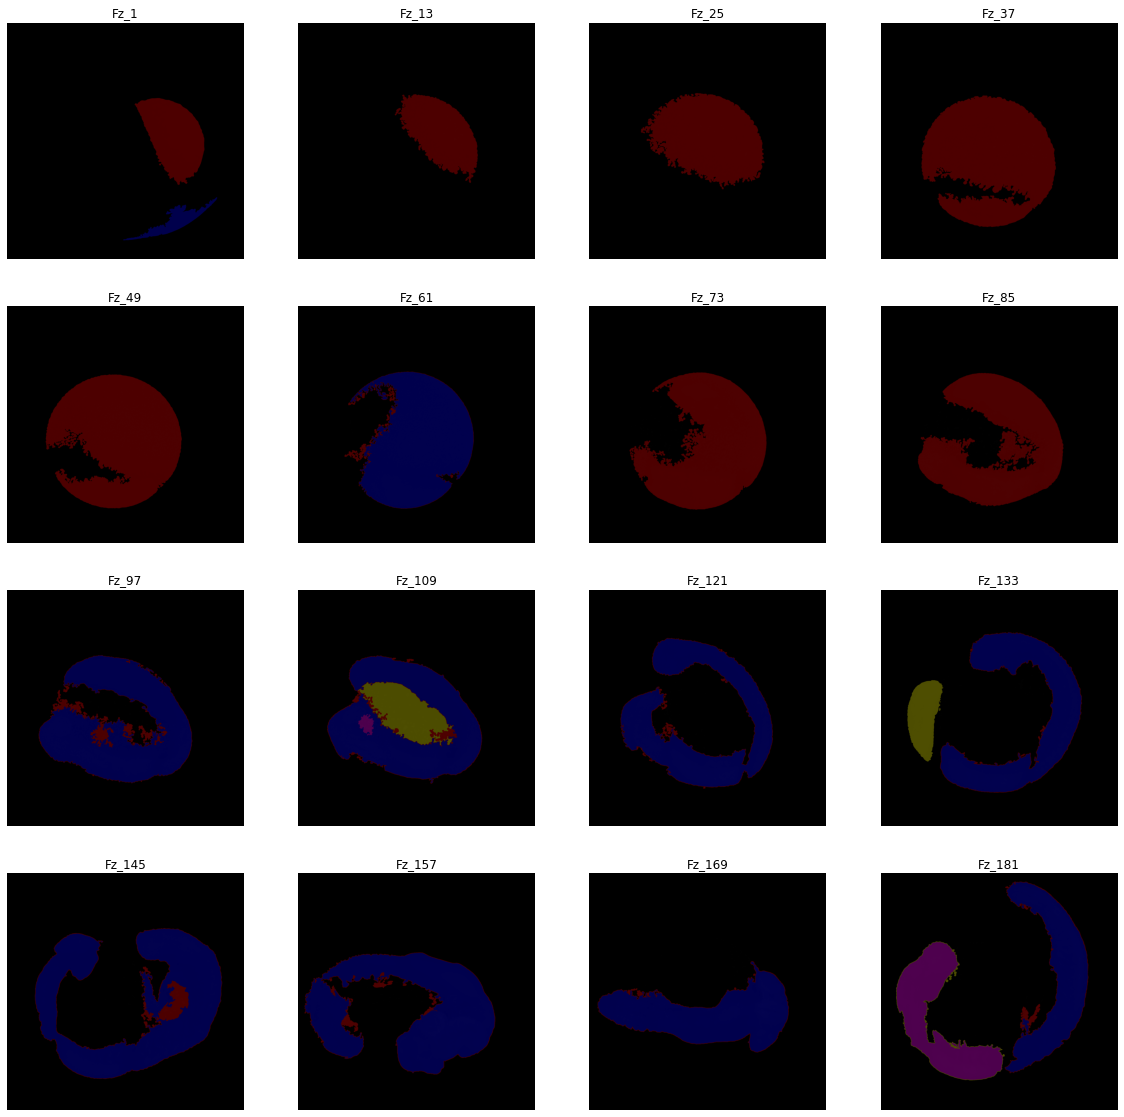

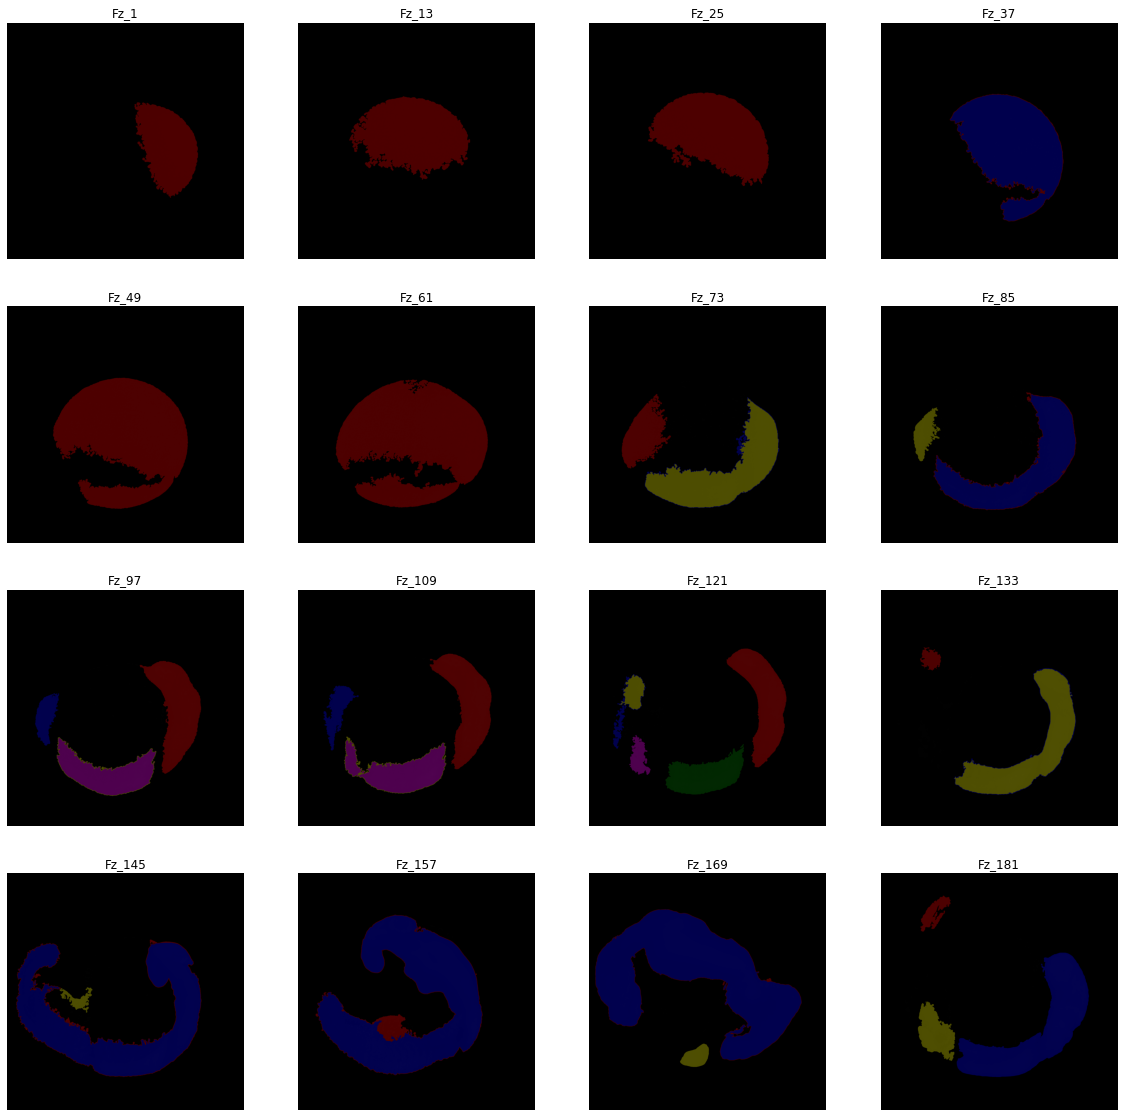

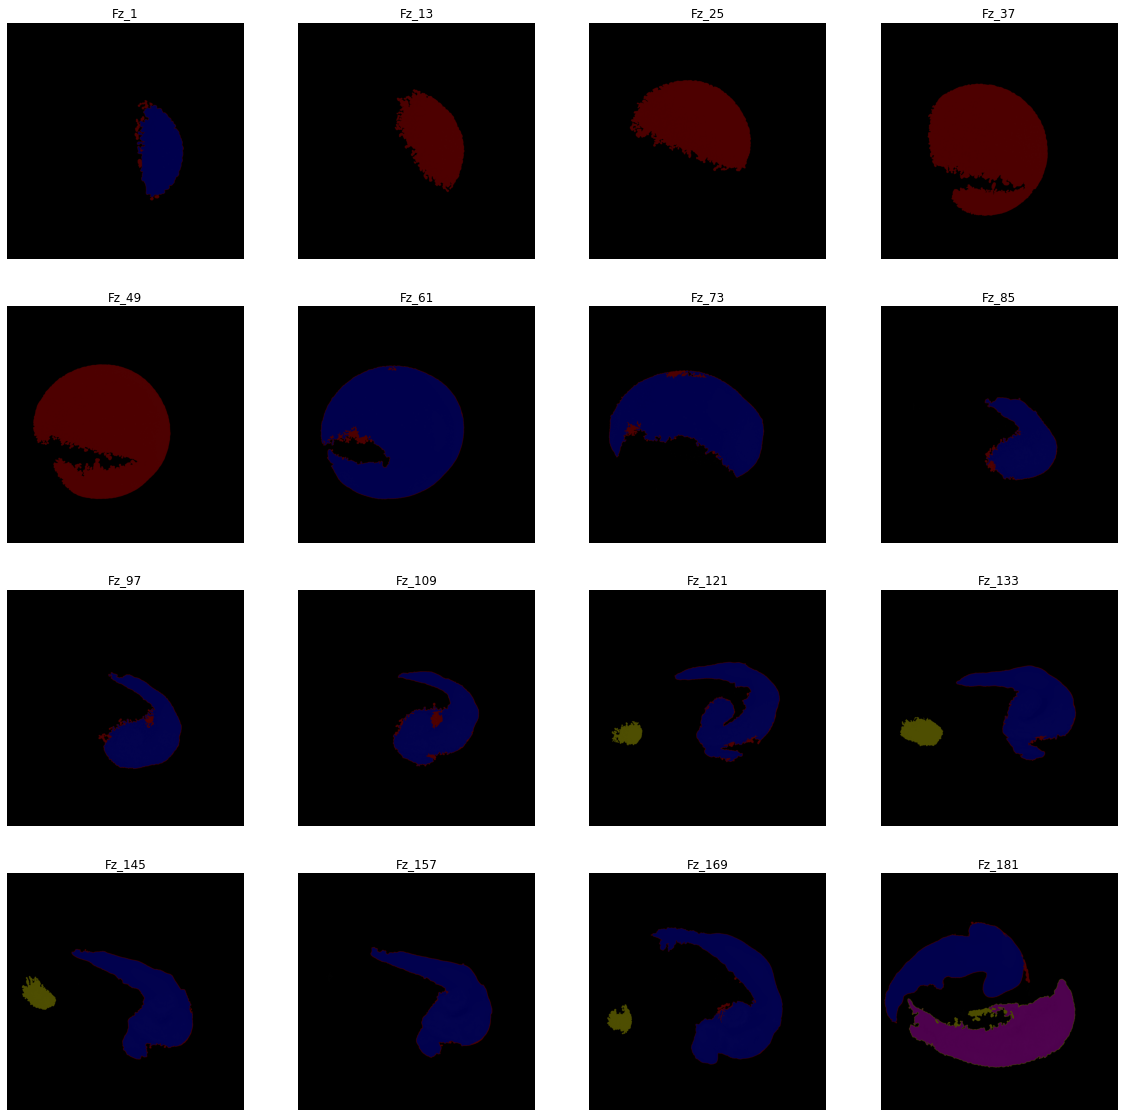

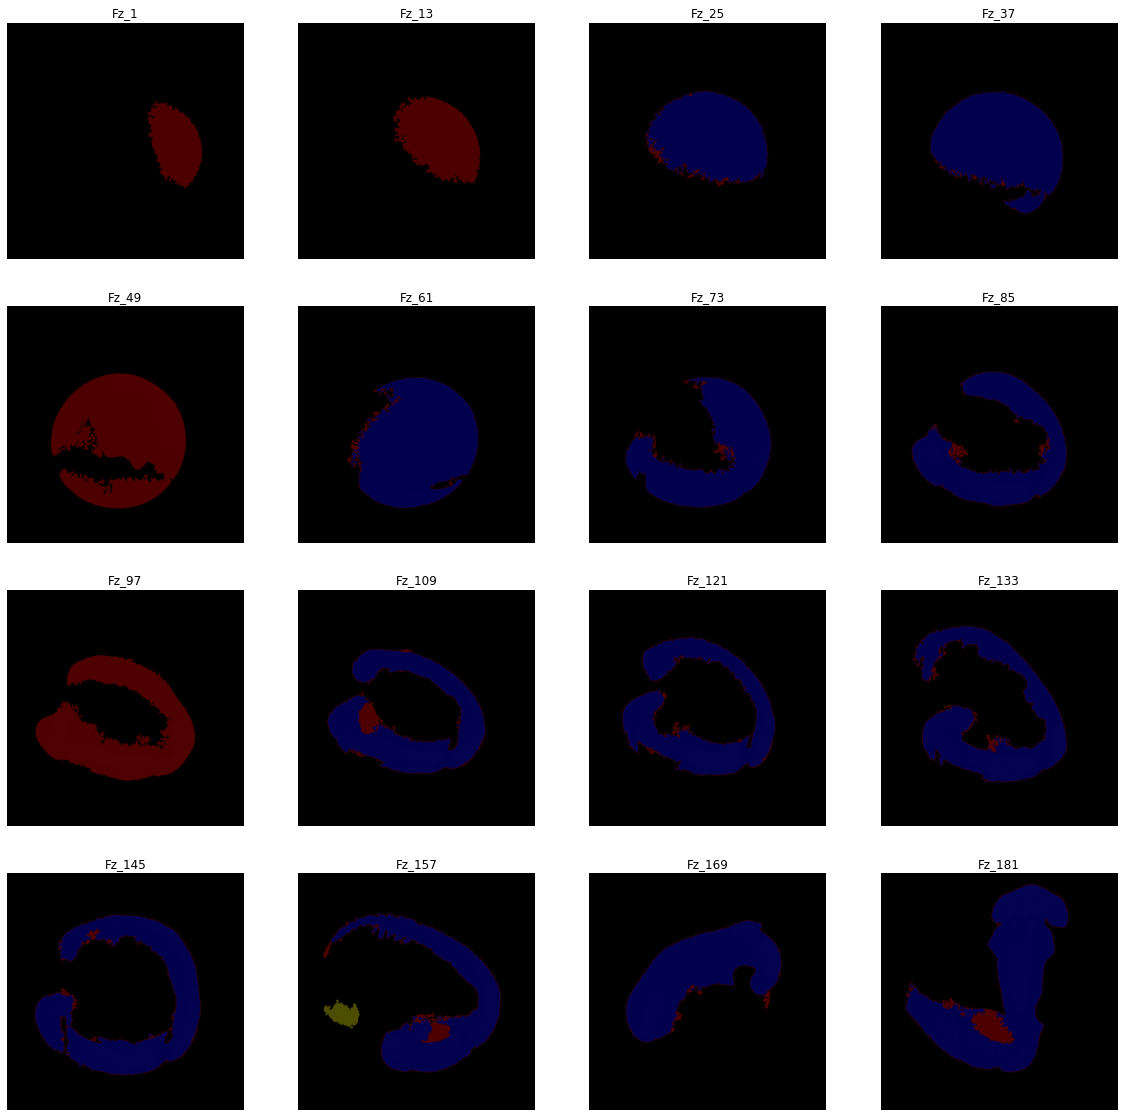

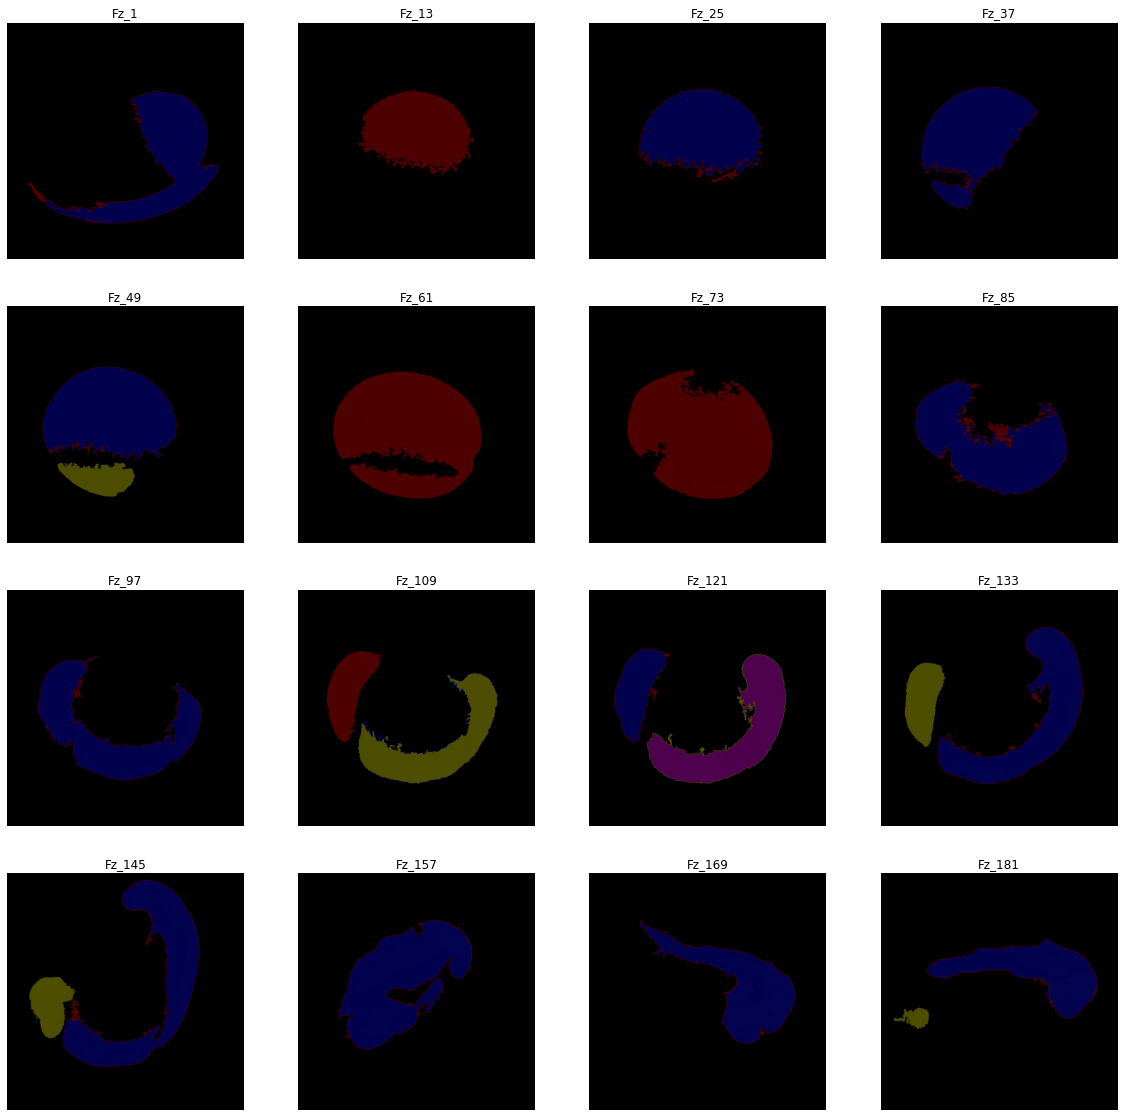

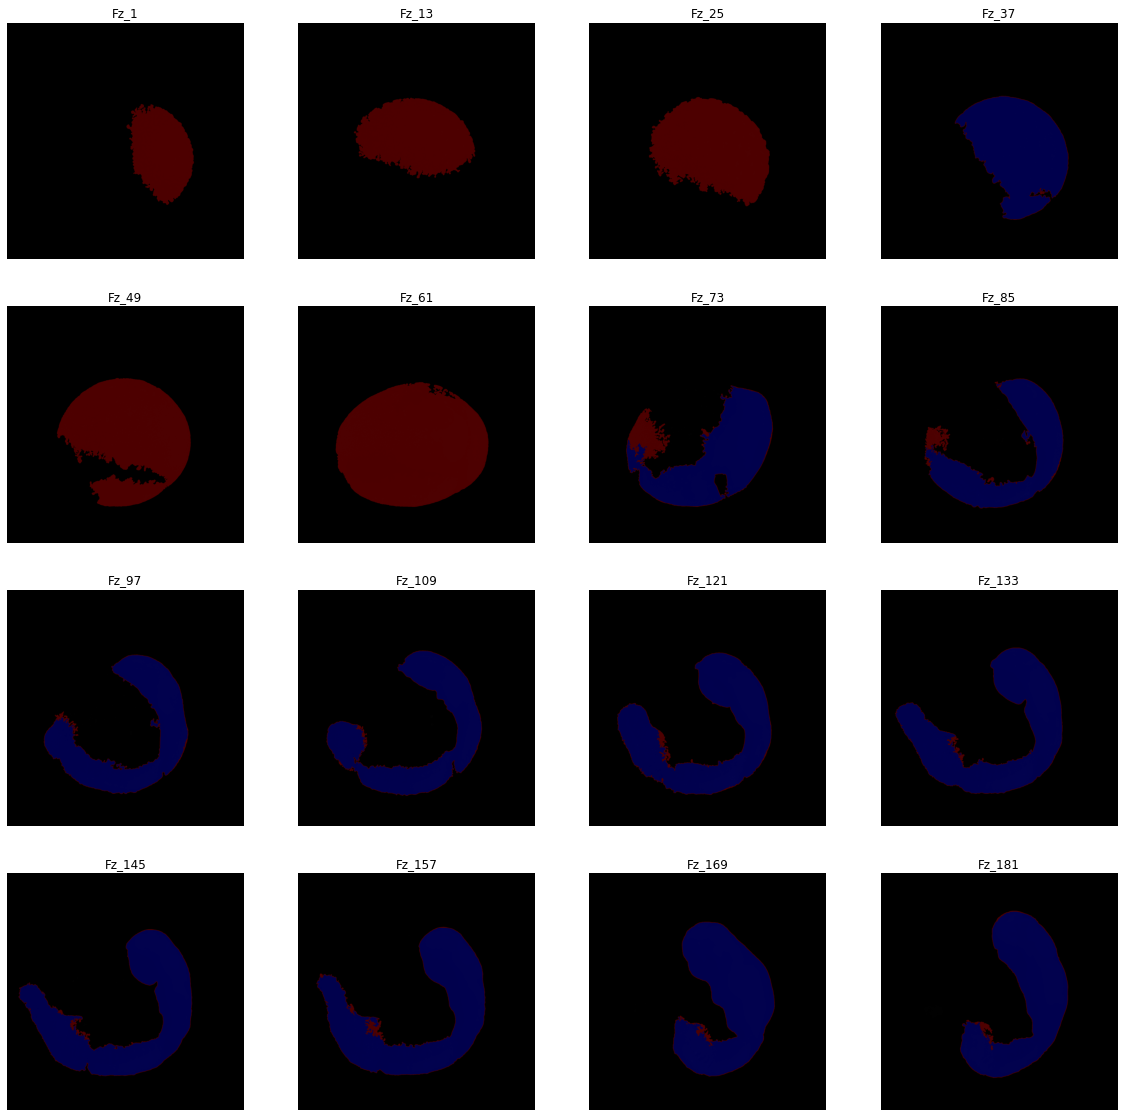

Error in callback <function flush_figures at 0x000001AA2533C550> (for post_execute):


KeyboardInterrupt: 

In [26]:
imageStack = glob.glob('D:/ZED/12MIPS/embryo*.tif') # stack of frames

#ensure output folder exists
outputDirectory = targetFolder+"otsu_fz"
outputDirectoryExistsCheck = os.path.exists(outputDirectory)
if not outputDirectoryExistsCheck:
    os.mkdir(outputDirectory)
    
#print (np.shape(imageStack))
s = 1
for stack in imageStack:
    stack = io.imread(stack)
    substack = stack[::12]
    #print (np.shape(stack))
    #print (np.shape(substack))
    n=0

    fig, ax = plt.subplots(4, 4, figsize=(20, 20))

    for slice in substack:
        #print (np.shape(slice))
        #fig = plt.figure(figsize=(6, 6))
        slice_g = filters.gaussian(slice, sigma=gaussianSigma, preserve_range=True)
        
        hist_threshold = filters.threshold_otsu(slice_g)
        mask = slice_g > hist_threshold
        slice_t = slice * mask
        
        segments_fz = segmentation.felzenszwalb(slice_t, scale=fzScale, sigma=1, min_size=15000)
        out_fz = color.label2rgb(segments_fz, slice_t, bg_label=0)
        a=int(np.floor(n/4))
        b = int(n%4)
        ax[a,b].imshow(out_fz)
        ax[a,b].set_title("Fz_"+str(1+n*12))
        ax[a,b].axis('off')
        n=n+1
    
    imageFileName = targetFolder+"otsu_fz"+"/embryo_"+str(s)+".tif"

    plt.savefig(imageFileName, transparent=True)
    s=s+1

In [6]:
#Stop Iteration error means the outputDirectory is not found - did you delete, move,rename the folder?
outputDirectory = targetFolder+"ProblemSet_Scan"
root, dirs, files = next(os.walk(outputDirectory, topdown=True))
files = [ os.path.join(root, f) for f in files ]
print(files)
tifftools.tiff_concat(files, targetFolder+"combined_tifs/ProblemSet_Scan"+".tif", overwrite=True)

['D:/ZED/12MIPS/ProblemSet_Scan\\embryo_E11T13_test.tif', 'D:/ZED/12MIPS/ProblemSet_Scan\\embryo_E11T1_test.tif', 'D:/ZED/12MIPS/ProblemSet_Scan\\embryo_E12T73_test.tif', 'D:/ZED/12MIPS/ProblemSet_Scan\\embryo_E2T1_test.tif', 'D:/ZED/12MIPS/ProblemSet_Scan\\embryo_E2T61_test.tif', 'D:/ZED/12MIPS/ProblemSet_Scan\\embryo_E4T181_test.tif', 'D:/ZED/12MIPS/ProblemSet_Scan\\embryo_E6T181_test.tif', 'D:/ZED/12MIPS/ProblemSet_Scan\\embryo_E6T61_test.tif', 'D:/ZED/12MIPS/ProblemSet_Scan\\embryo_E7T181_test.tif', 'D:/ZED/12MIPS/ProblemSet_Scan\\embryo_E8T1_test.tif', 'D:/ZED/12MIPS/ProblemSet_Scan\\embryo_E8T61_test.tif', 'D:/ZED/12MIPS/ProblemSet_Scan\\embryo_E9T181_test.tif', 'D:/ZED/12MIPS/ProblemSet_Scan\\embryo_E9T61_test.tif']


(-0.5, 511.5, 511.5, -0.5)

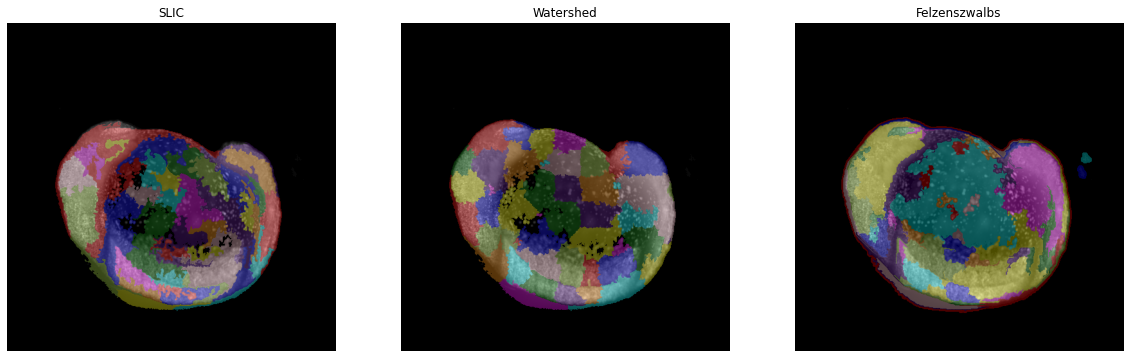

In [150]:
# Adopted from: https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_segmentations.html

### SLIC
segments_slic = segmentation.slic(slice_t, n_segments=100, compactness=0.01, sigma=1, start_label=1, mask=mask)
out_slic = color.label2rgb(segments_slic, slice_t, bg_label=0)

### watershed
gradient = filters.sobel(slice_t)
segments_watershed = segmentation.watershed(gradient, markers=50, compactness=0.001, mask=mask)
out_watershed = color.label2rgb(segments_watershed, slice_t, bg_label=0)

### felzenszwalb’s efficient graph based segmentation
segments_fz = segmentation.felzenszwalb(slice_t, scale=50, sigma=1, min_size=200)
out_fz = color.label2rgb(segments_fz, slice_t, bg_label=0)

fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(out_slic)
ax[0].set_title('SLIC')
ax[0].axis('off')
ax[1].set_title('Watershed')
ax[1].imshow(out_watershed)
ax[1].axis('off')
ax[2].set_title('Felzenszwalbs')
ax[2].imshow(out_fz)
ax[2].axis('off')

## Merge superpixels

(-0.5, 511.5, 511.5, -0.5)

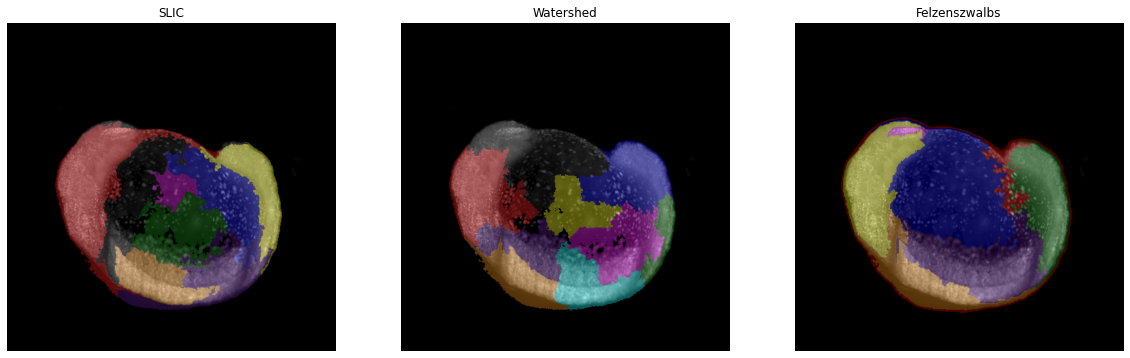

In [115]:
# Adopted from: https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_ncut.html

### n-cut
def n_cut(img, segments):
    g = graph.rag_mean_color(img, segments, mode='similarity', sigma=10) # construct a graph by connecting the superpixels
    segments_cut = graph.cut_normalized(segments, g, thresh=0.5, num_cuts=20)
    out_cut = color.label2rgb(segments_cut, img, bg_label=0)
    return out_cut

slic_cut = n_cut(slice_t, segments_slic)
watershed_cut = n_cut(slice_t, segments_watershed)
fz_cut = n_cut(slice_t, segments_fz)

fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(slic_cut)
ax[0].set_title('SLIC')
ax[0].axis('off')
ax[1].set_title('Watershed')
ax[1].imshow(watershed_cut)
ax[1].axis('off')
ax[2].set_title('Felzenszwalbs')
ax[2].imshow(fz_cut)
ax[2].axis('off')

(-0.5, 511.5, 511.5, -0.5)

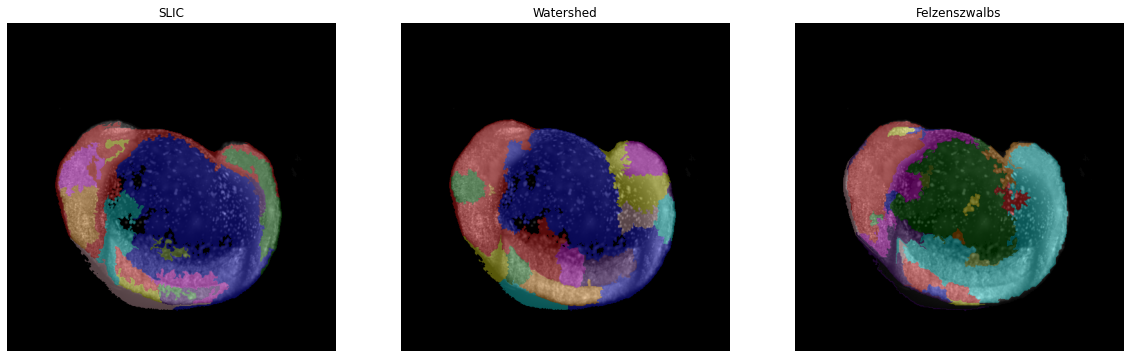

In [138]:
# Adopted from: https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_rag_mean_color.html#sphx-glr-auto-examples-segmentation-plot-rag-mean-color-py

### threshod cut
def t_cut(img, segments):
    g = graph.rag_mean_color(img, segments, mode='distance')
    segments_cut = graph.cut_threshold(segments, g, thresh=0.08)
    out_cut = color.label2rgb(segments_cut, img, bg_label=0)
    return out_cut

slic_cut = t_cut(slice_t, segments_slic)
watershed_cut = t_cut(slice_t, segments_watershed)
fz_cut = t_cut(slice_t, segments_fz)

fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(slic_cut)
ax[0].set_title('SLIC')
ax[0].axis('off')
ax[1].set_title('Watershed')
ax[1].imshow(watershed_cut)
ax[1].axis('off')
ax[2].set_title('Felzenszwalbs')
ax[2].imshow(fz_cut)
ax[2].axis('off')

(-0.5, 511.5, 511.5, -0.5)

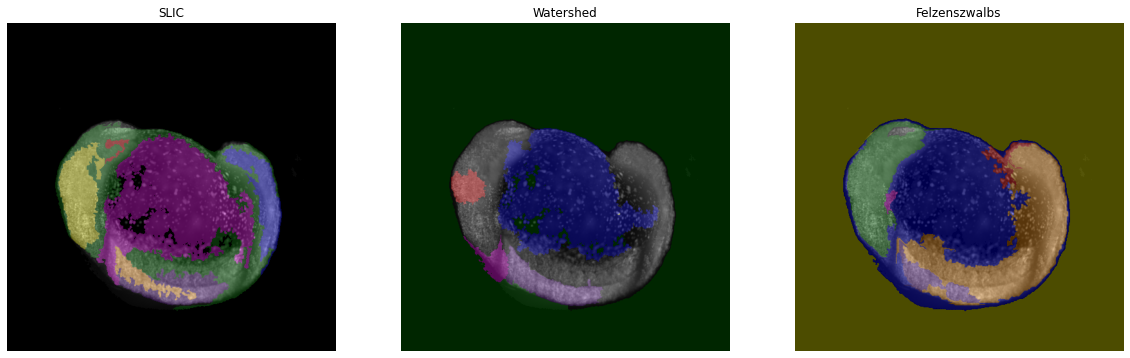

In [149]:
# Adopted from: https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_rag_merge.html#sphx-glr-auto-examples-segmentation-plot-rag-merge-py

### RAG merging
def _weight_mean_color(graph, src, dst, n):
    """Callback to handle merging nodes by recomputing mean color.

    The method expects that the mean color of `dst` is already computed.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    n : int
        A neighbor of `src` or `dst` or both.

    Returns
    -------
    data : dict
        A dictionary with the `"weight"` attribute set as the absolute
        difference of the mean color between node `dst` and `n`.
    """

    diff = graph.nodes[dst]['mean color'] - graph.nodes[n]['mean color']
    diff = np.linalg.norm(diff)
    return {'weight': diff}


def merge_mean_color(graph, src, dst):
    """Callback called before merging two nodes of a mean color distance graph.

    This method computes the mean color of `dst`.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    """
    graph.nodes[dst]['total color'] += graph.nodes[src]['total color']
    graph.nodes[dst]['pixel count'] += graph.nodes[src]['pixel count']
    graph.nodes[dst]['mean color'] = (graph.nodes[dst]['total color'] /
                                      graph.nodes[dst]['pixel count'])

def m_h(img, segments):
    g = graph.rag_mean_color(img, segments, mode='distance')
    segments_mh = graph.merge_hierarchical(segments, g, thresh=0.2, rag_copy=False,
                                   in_place_merge=True,
                                   merge_func=merge_mean_color,
                                   weight_func=_weight_mean_color)
    out_mh = color.label2rgb(segments_mh, img, bg_label=0)
    return out_mh

slic_cut = m_h(slice_t, segments_slic)
watershed_cut = m_h(slice_t, segments_watershed)
fz_cut = m_h(slice_t, segments_fz)

fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(slic_cut)
ax[0].set_title('SLIC')
ax[0].axis('off')
ax[1].set_title('Watershed')
ax[1].imshow(watershed_cut)
ax[1].axis('off')
ax[2].set_title('Felzenszwalbs')
ax[2].imshow(fz_cut)
ax[2].axis('off')

## Combined folder run - segmentation and merging

In [6]:
### RAG merging
def _weight_mean_color(graph, src, dst, n):
    """Callback to handle merging nodes by recomputing mean color.

    The method expects that the mean color of `dst` is already computed.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    n : int
        A neighbor of `src` or `dst` or both.

    Returns
    -------
    data : dict
        A dictionary with the `"weight"` attribute set as the absolute
        difference of the mean color between node `dst` and `n`.
    """

    diff = graph.nodes[dst]['mean color'] - graph.nodes[n]['mean color']
    diff = np.linalg.norm(diff)
    return {'weight': diff}


def merge_mean_color(graph, src, dst):
    """Callback called before merging two nodes of a mean color distance graph.

    This method computes the mean color of `dst`.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    """
    graph.nodes[dst]['total color'] += graph.nodes[src]['total color']
    graph.nodes[dst]['pixel count'] += graph.nodes[src]['pixel count']
    graph.nodes[dst]['mean color'] = (graph.nodes[dst]['total color'] /
                                      graph.nodes[dst]['pixel count'])

def m_h(img, segments):
    g = graph.rag_mean_color(img, segments, mode='distance')
    segments_mh = graph.merge_hierarchical(segments, g, thresh=0.2, rag_copy=False,
                                   in_place_merge=True,
                                   merge_func=merge_mean_color,
                                   weight_func=_weight_mean_color)
    out_mh = color.label2rgb(segments_mh, img, bg_label=0)
    return out_mh




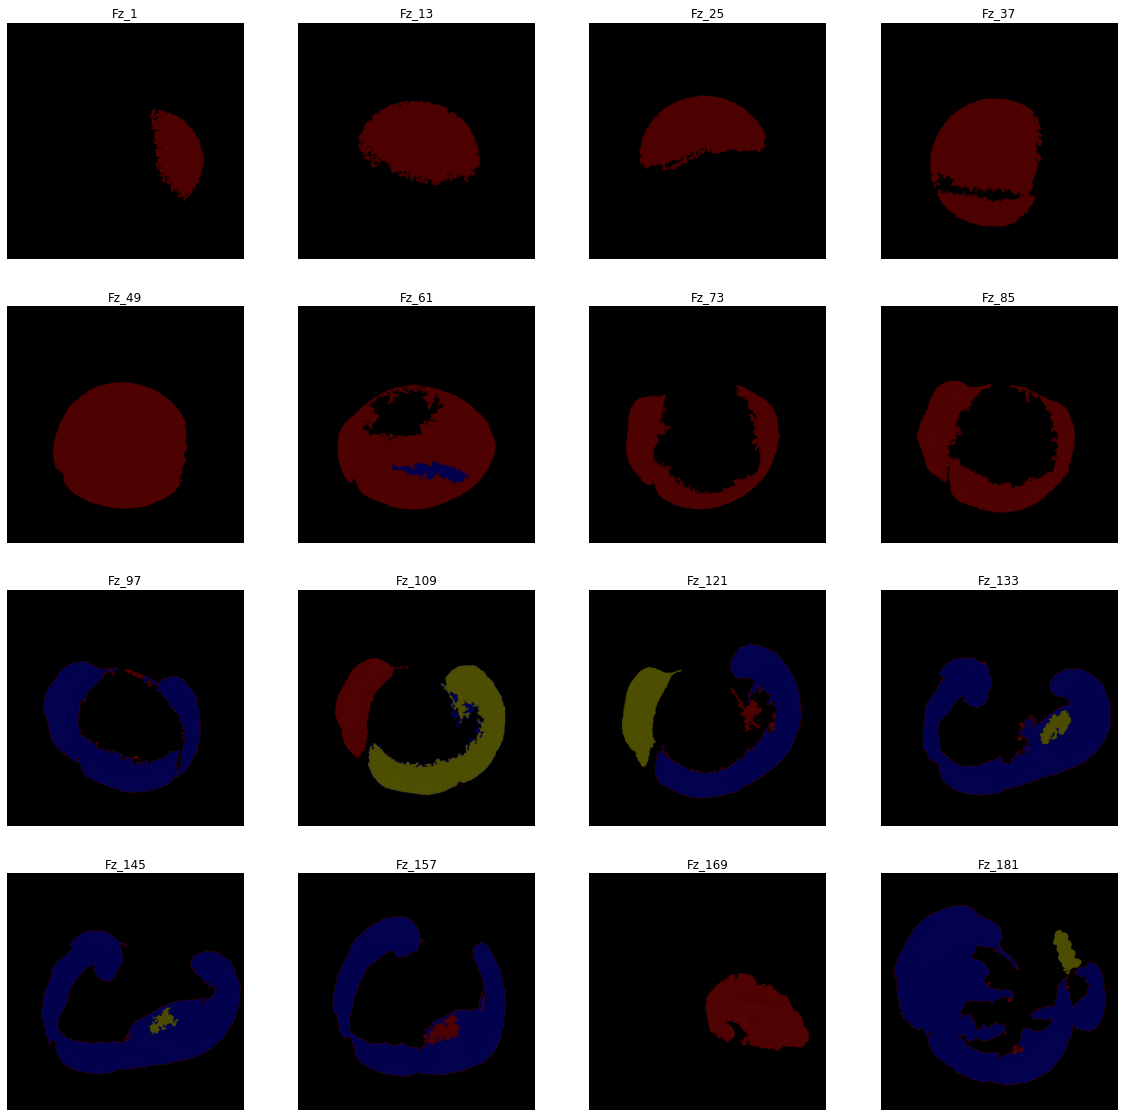

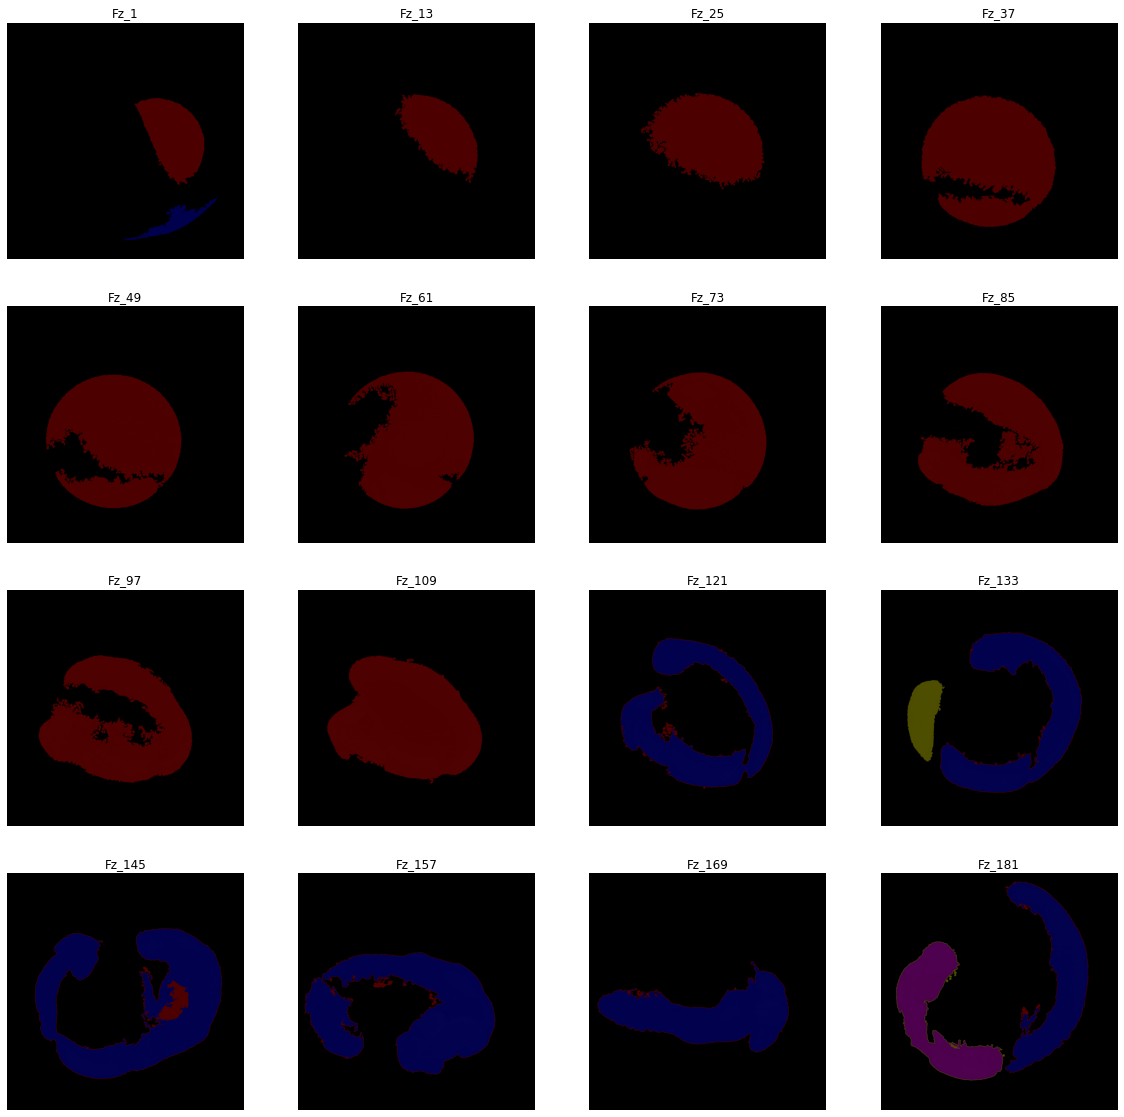

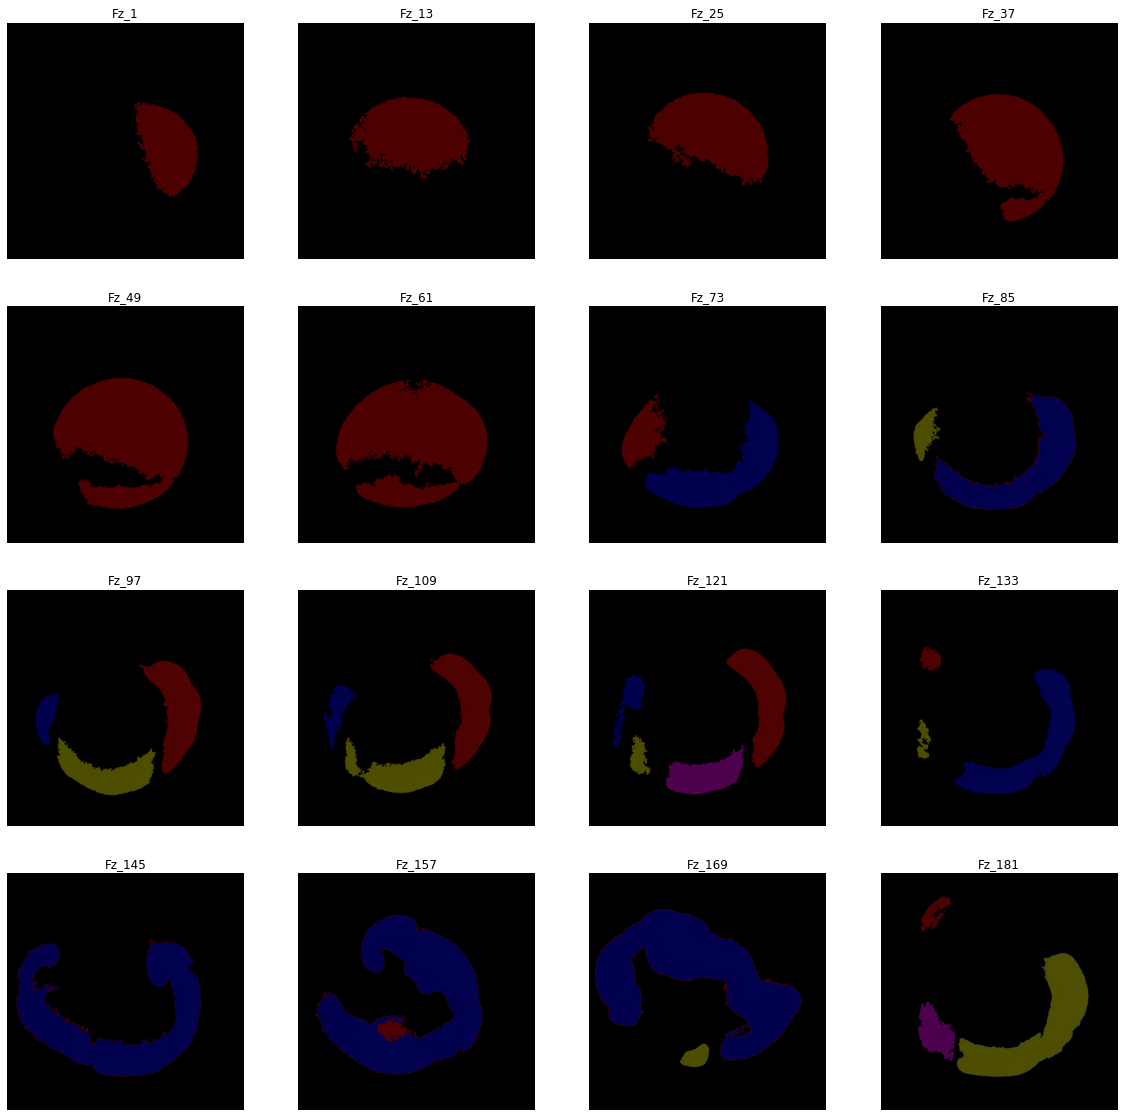

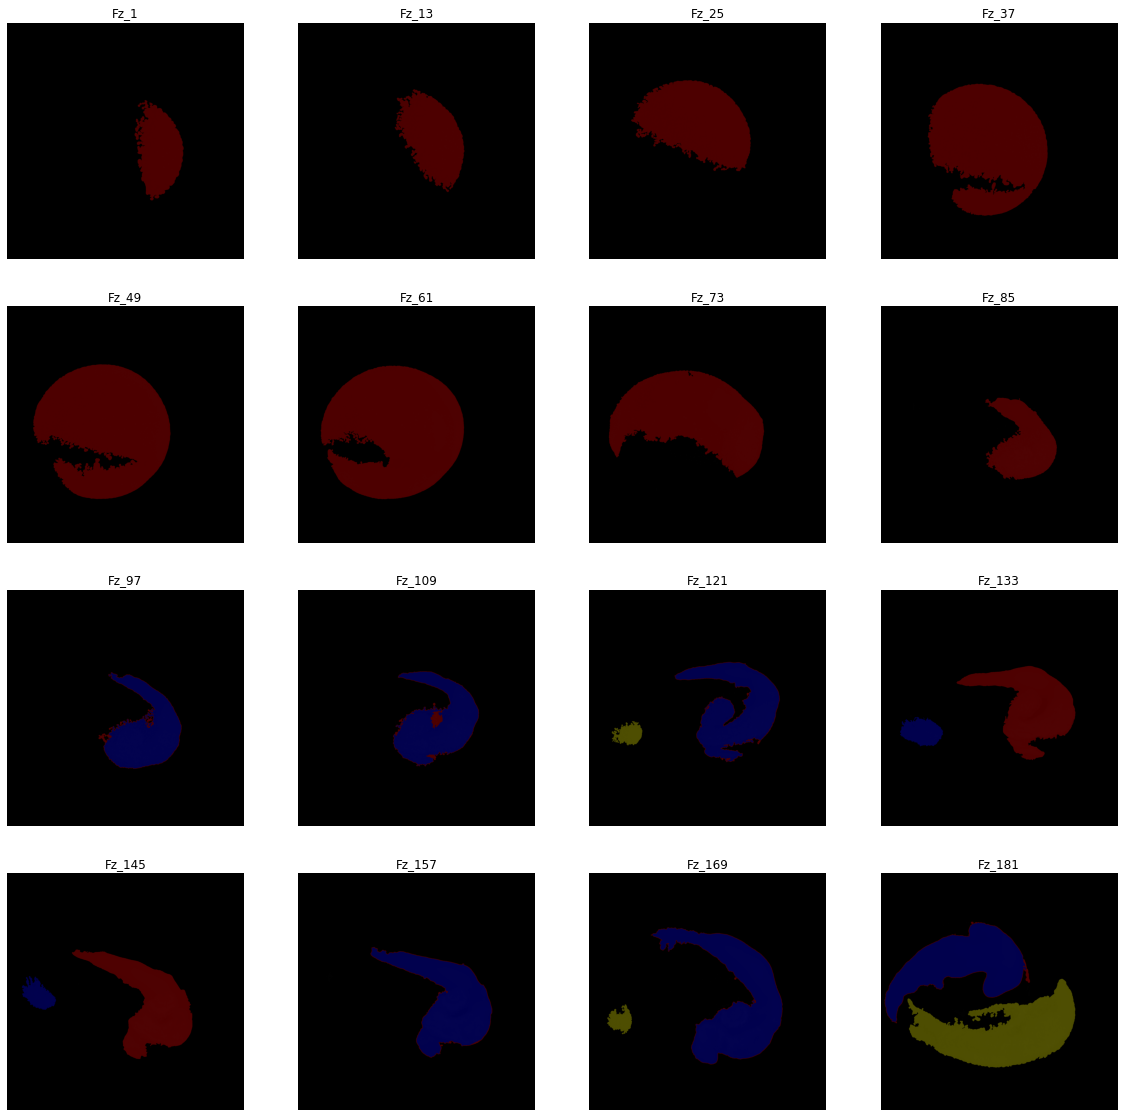

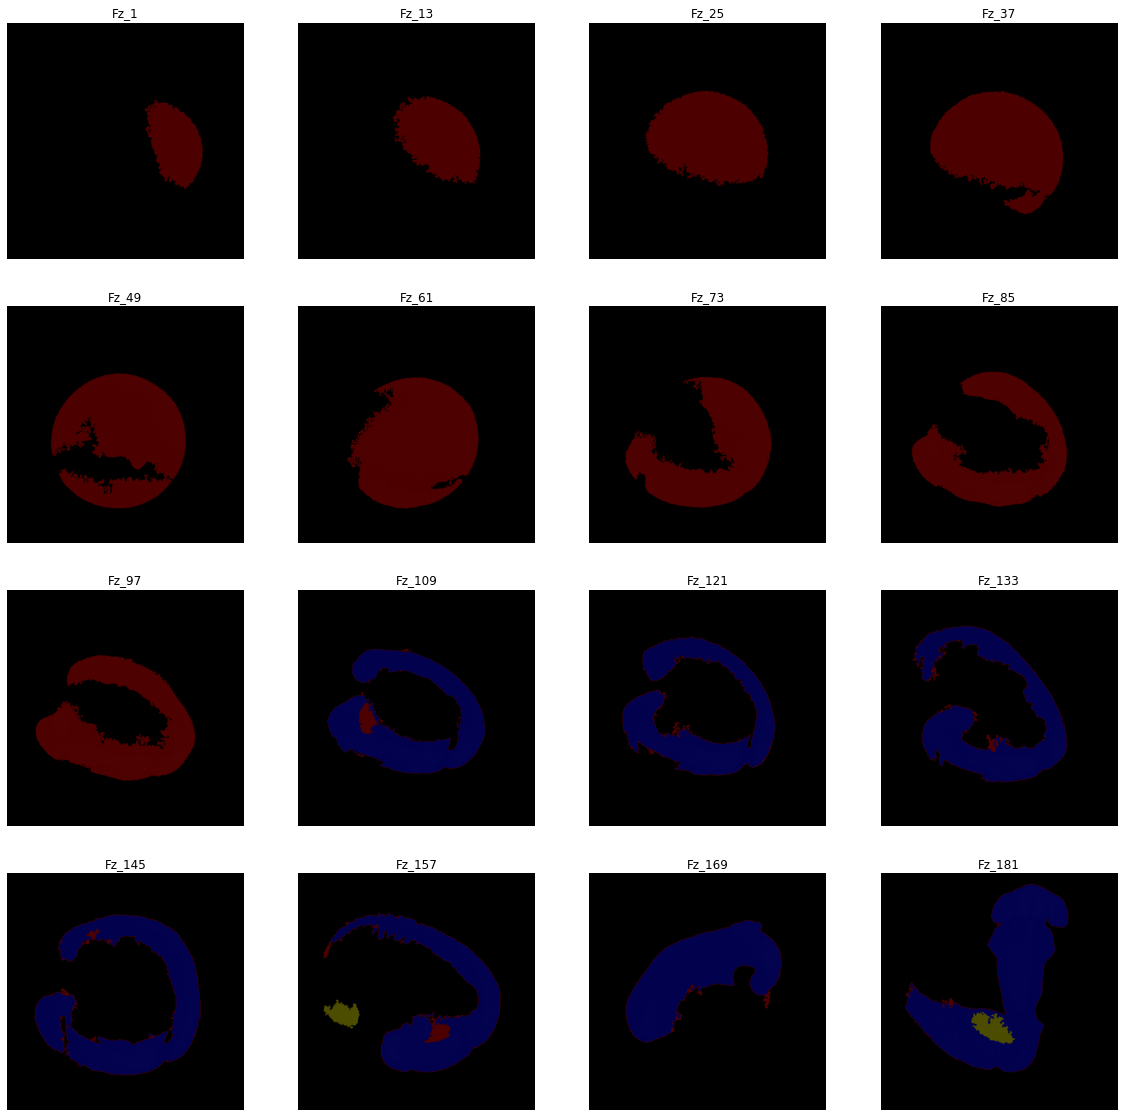

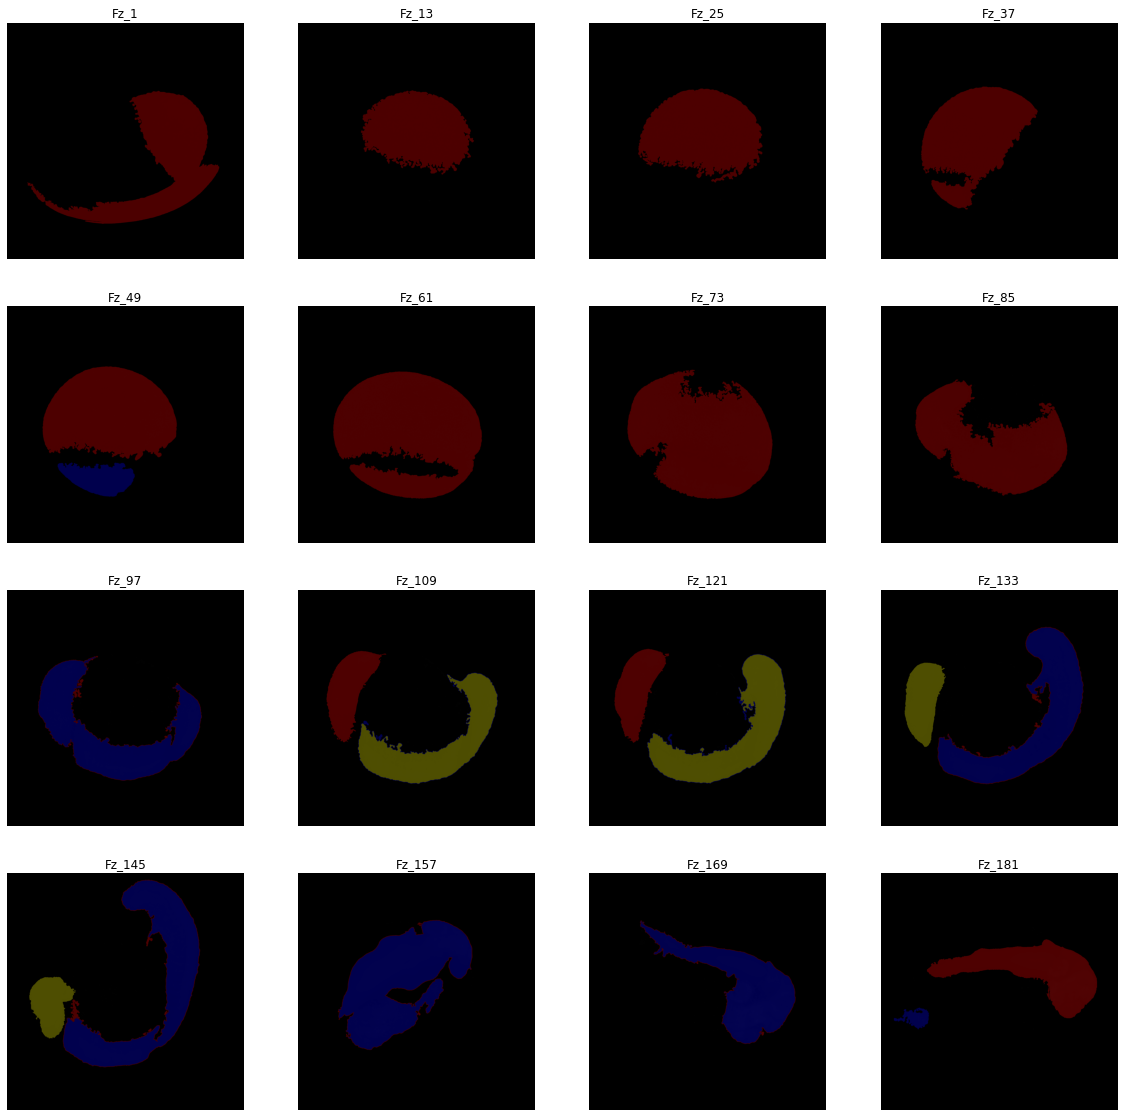

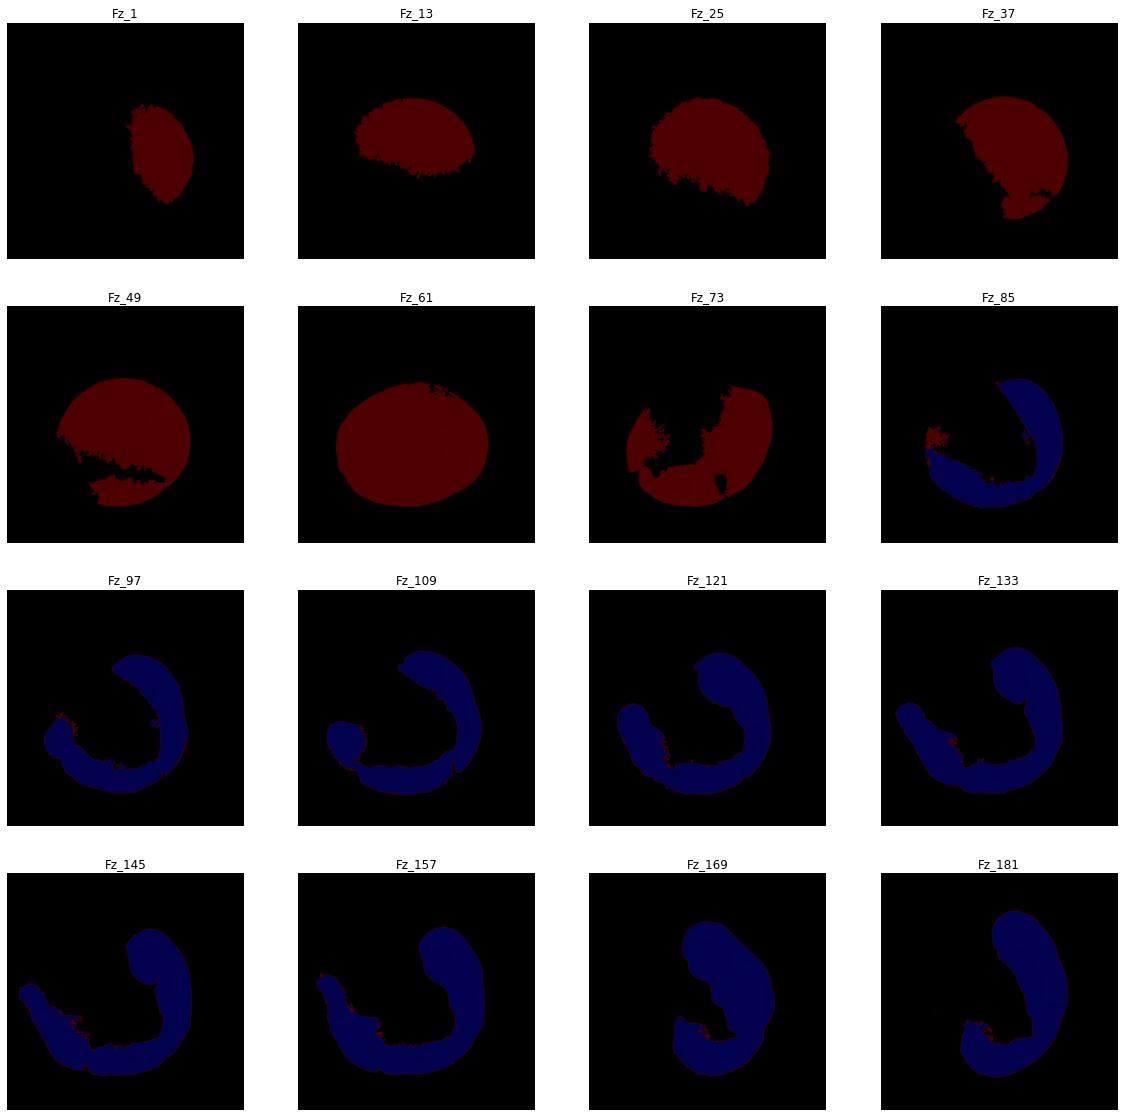

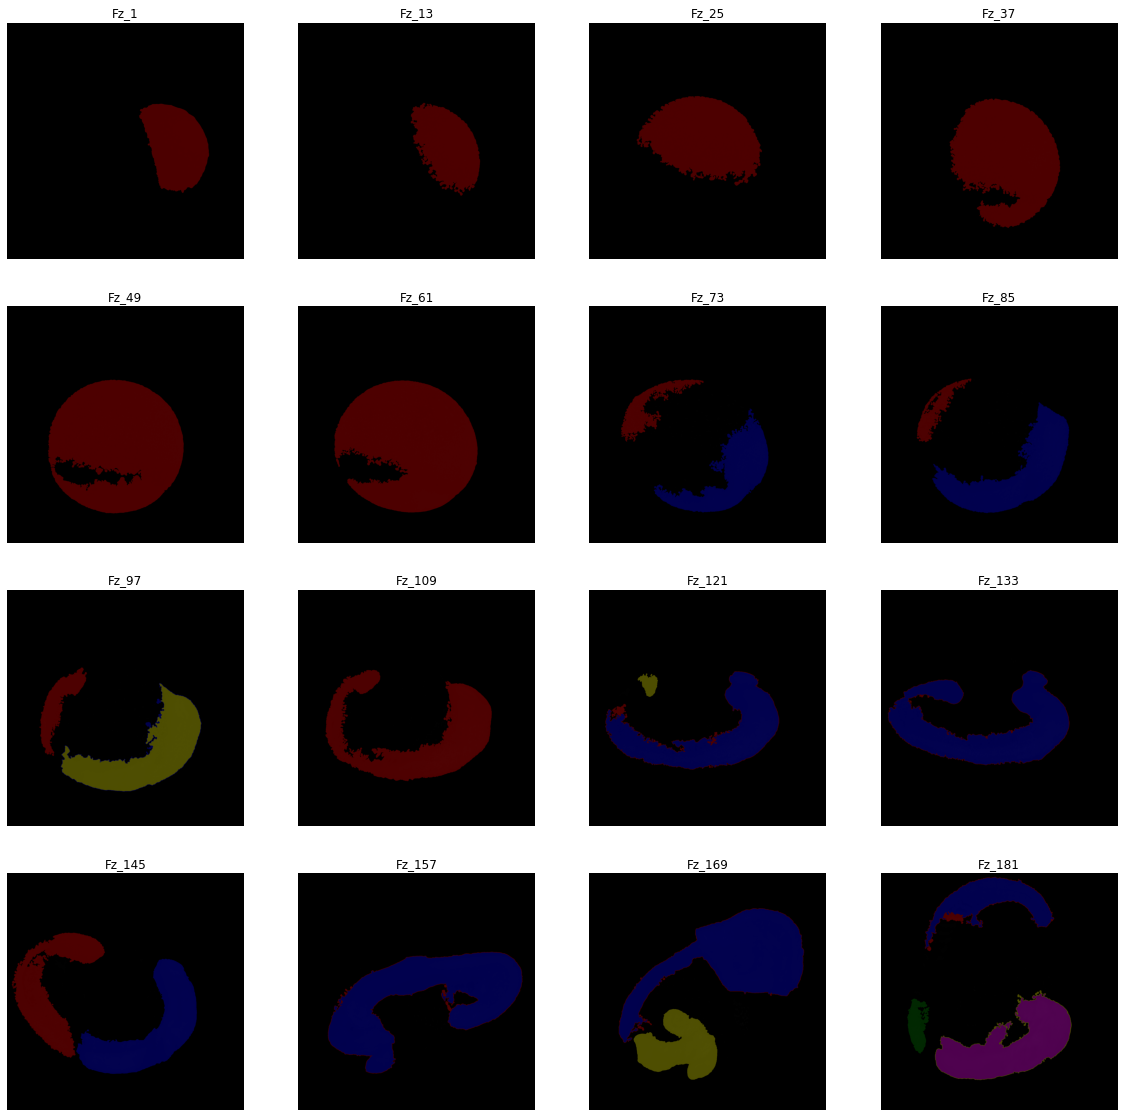

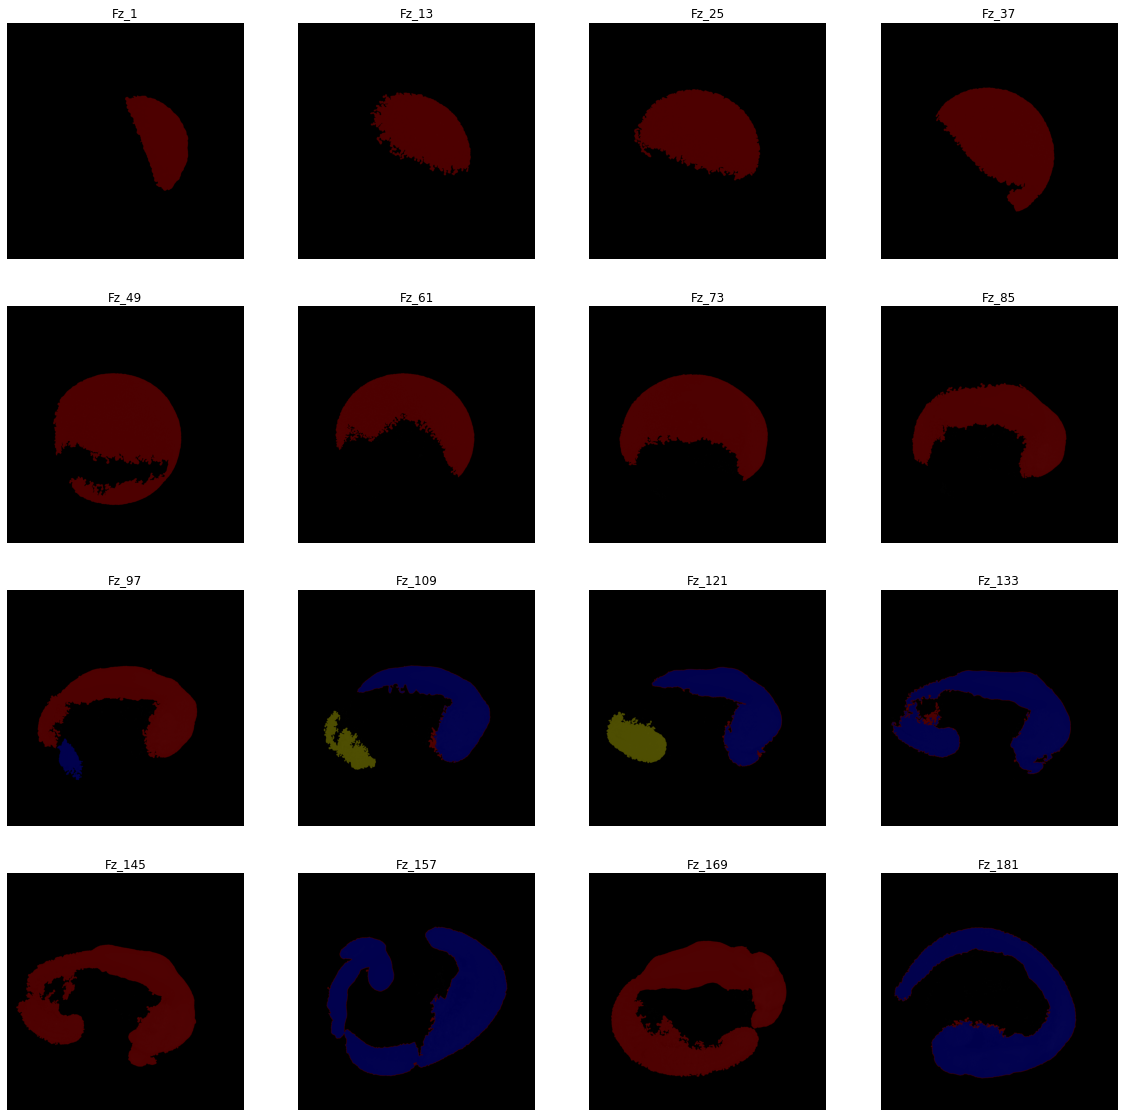

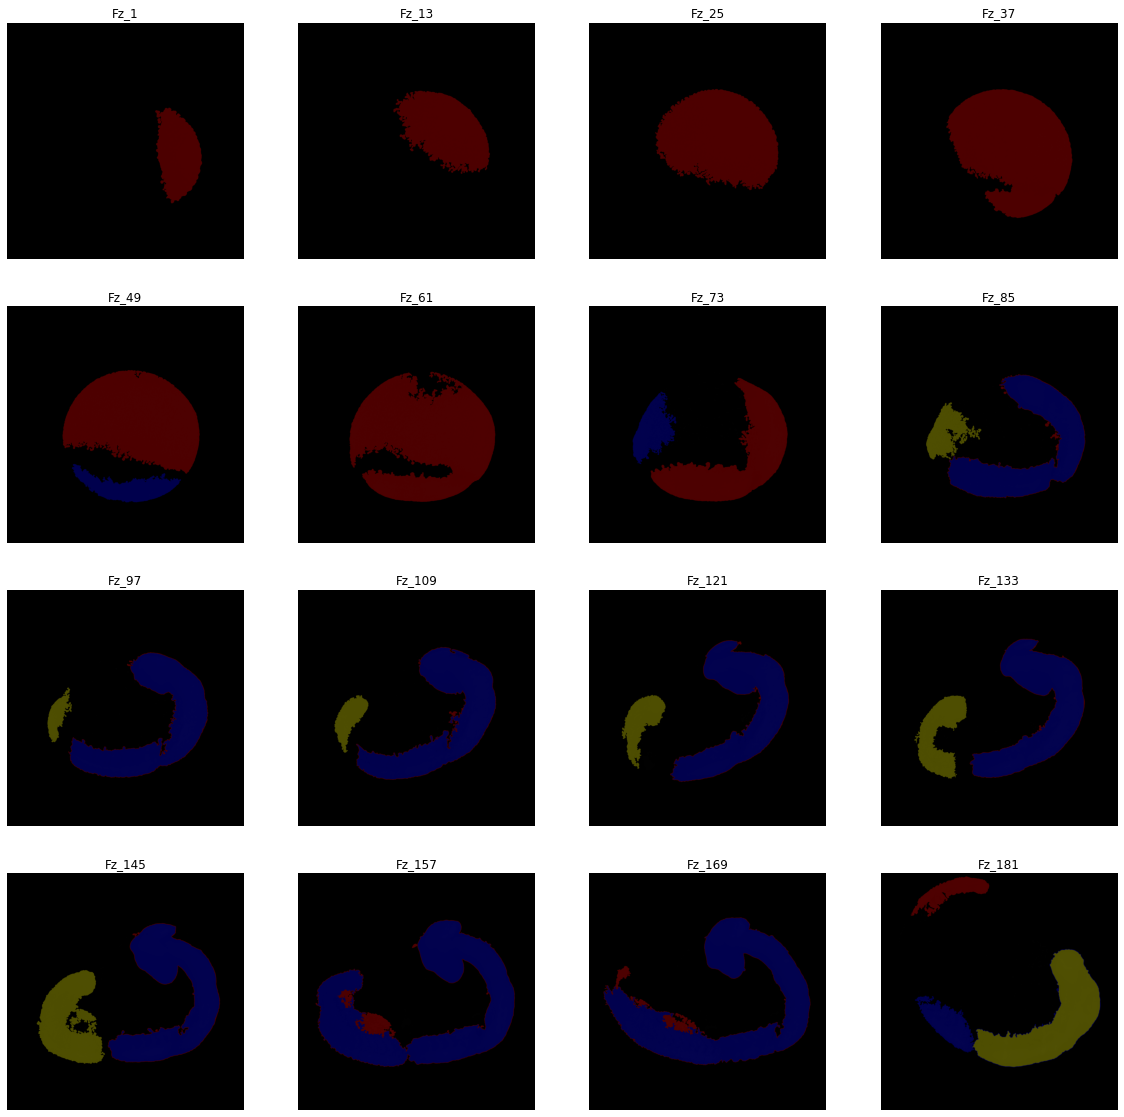

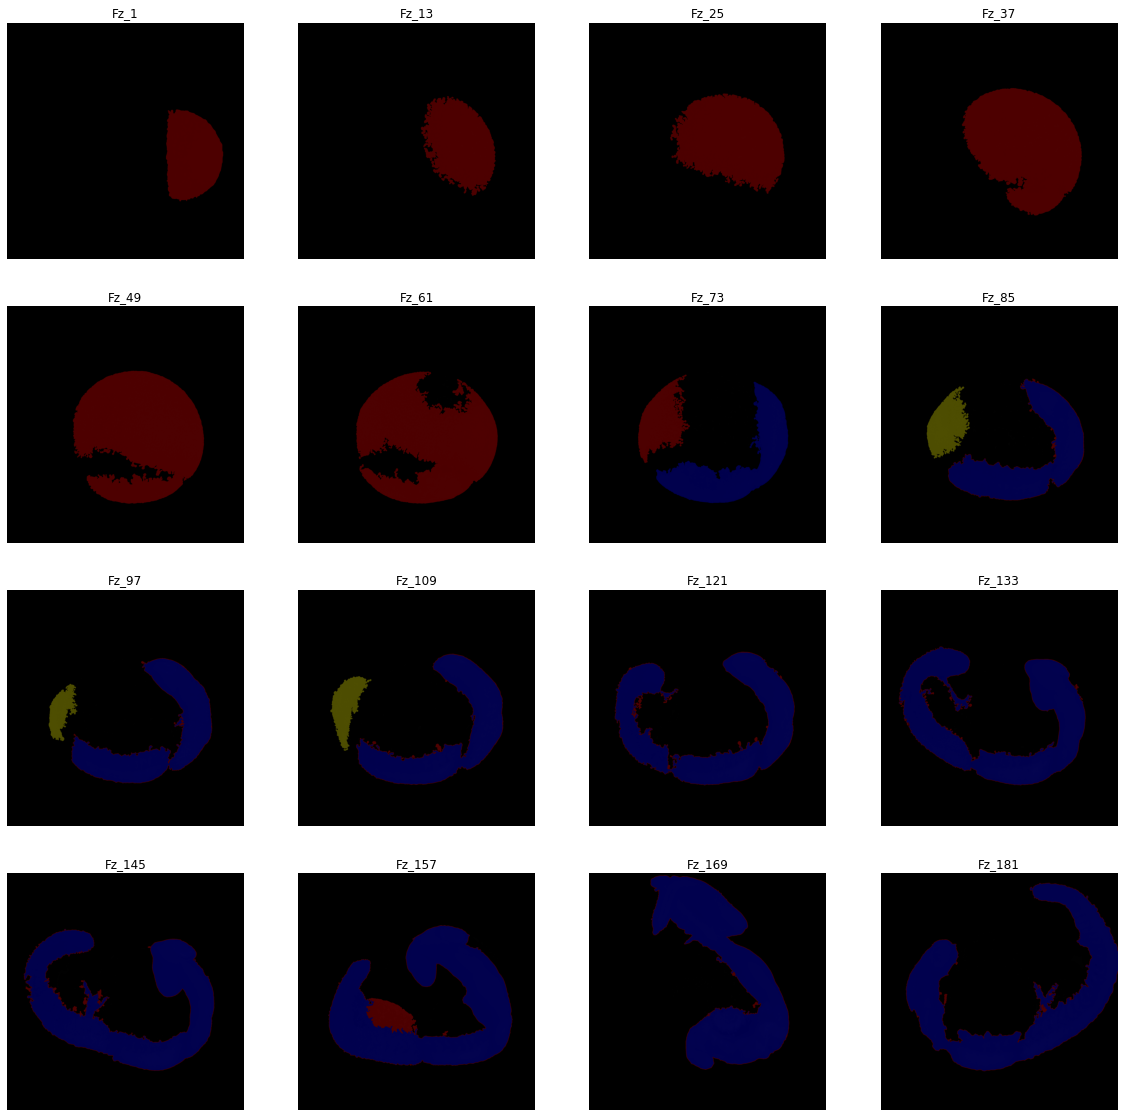

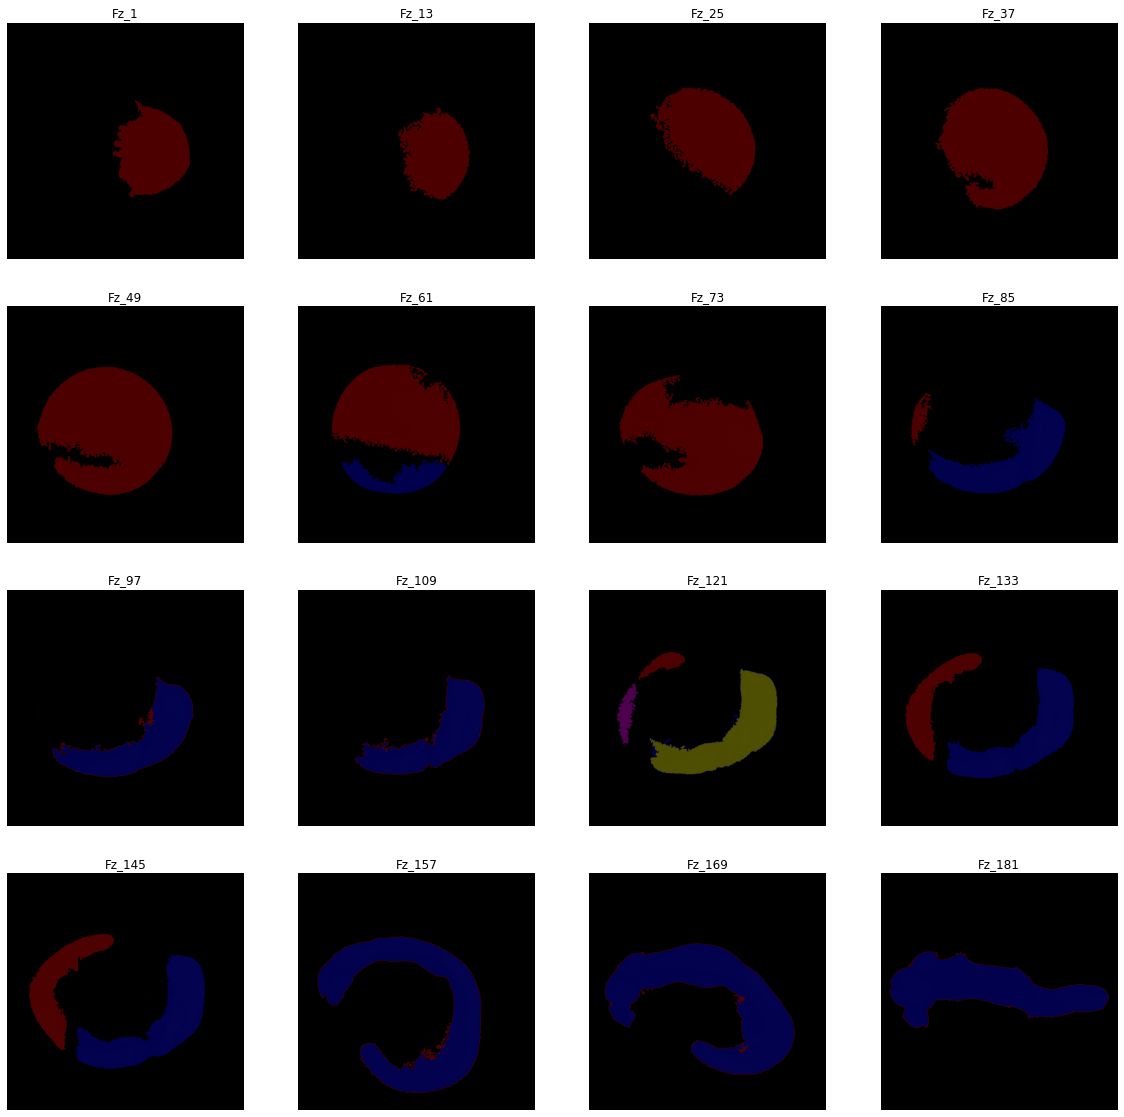

In [7]:
imageStack = glob.glob('D:/ZED/12MIPS/embryo*.tif') # stack of frames

#ensure output folder exists
outputDirectory = targetFolder+"otsu_fz_RAG"
outputDirectoryExistsCheck = os.path.exists(outputDirectory)
if not outputDirectoryExistsCheck:
    os.mkdir(outputDirectory)
    
#print (np.shape(imageStack))
s = 1
for stack in imageStack:
    stack = io.imread(stack)
    substack = stack[::12]
    #print (np.shape(stack))
    #print (np.shape(substack))
    n=0

    fig, ax = plt.subplots(4, 4, figsize=(20, 20))

    for slice in substack:
        #print (np.shape(slice))
        #fig = plt.figure(figsize=(6, 6))
        slice_g = filters.gaussian(slice, sigma=gaussianSigma, preserve_range=True)
        
        hist_threshold = filters.threshold_otsu(slice_g)
        mask = slice_g > hist_threshold
        slice_t = slice * mask
        
        segments_fz = segmentation.felzenszwalb(slice_t, scale=fzScale, sigma=1, min_size=fz_minimum_size)

        fz_cut = m_h(slice_t, segments_fz)

        a=int(np.floor(n/4))
        b = int(n%4)
        ax[a,b].imshow(fz_cut)
        ax[a,b].set_title("Fz_"+str(1+n*12))
        ax[a,b].axis('off')
        n=n+1
    
    imageFileName = targetFolder+"combined_tifs/otsu_fz_RAG"+"/embryo_"+str(s)+".tif"

    plt.savefig(imageFileName, transparent=True)
    s=s+1
#########################################




In [8]:
#Stop Iteration error means the outputDirectory is not found - did you delete, move,rename the folder?
outputDirectory = targetFolder+"otsu_fz_RAG"
root, dirs, files = next(os.walk(outputDirectory, topdown=True))
files = [ os.path.join(root, f) for f in files ]
print(files)
tifftools.tiff_concat(files, targetFolder+"otsu_fz"+".tif", overwrite=True)

['D:/ZED/12MIPS/otsu_fz_RAG\\embryo_1.tif', 'D:/ZED/12MIPS/otsu_fz_RAG\\embryo_10.tif', 'D:/ZED/12MIPS/otsu_fz_RAG\\embryo_11.tif', 'D:/ZED/12MIPS/otsu_fz_RAG\\embryo_12.tif', 'D:/ZED/12MIPS/otsu_fz_RAG\\embryo_2.tif', 'D:/ZED/12MIPS/otsu_fz_RAG\\embryo_3.tif', 'D:/ZED/12MIPS/otsu_fz_RAG\\embryo_4.tif', 'D:/ZED/12MIPS/otsu_fz_RAG\\embryo_5.tif', 'D:/ZED/12MIPS/otsu_fz_RAG\\embryo_6.tif', 'D:/ZED/12MIPS/otsu_fz_RAG\\embryo_7.tif', 'D:/ZED/12MIPS/otsu_fz_RAG\\embryo_8.tif', 'D:/ZED/12MIPS/otsu_fz_RAG\\embryo_9.tif']
